# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()
farthest_point = manager.dict()

# Non shared resources
epochs = 10
batch_size = 64
sequence_length = 80

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/undersampled.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (3328, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,USER USER USER USER BANCI KALENG MALU GA BISA ...,1,1,1,0,0,0,0,1,0,1,0,0
1,USER Bu guru enakan jadi jablay atau guru esde...,1,1,1,0,0,0,0,1,0,1,0,0
2,Jadi cowo itu harus Gantle kalo ga Gantle itu ...,1,1,0,1,0,0,0,1,0,0,1,0
3,USER Awaasss... Jgn sampe beritanya sampe ke a...,1,1,1,0,0,0,1,0,0,1,0,0
4,USER udah biasa kali. Gue kpoper tapi kalo ngo...,1,1,1,0,0,0,0,1,0,1,0,0


In [7]:
data.HS.value_counts()

HS
0    1882
1    1446
Name: count, dtype: int64

In [8]:
data.Abusive.value_counts()

Abusive
0    1882
1    1446
Name: count, dtype: int64

In [9]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (1888, 13)
Non-toxic shape:  (1440, 13)


In [10]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [11]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [12]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [13]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2662,) (2662, 12)
(666,) (666, 12)


In [14]:
hs_mask = (
    (val_data['Abusive'] == 0) & 
    (val_data['HS'] == 0)
)
hs = val_data[hs_mask]
print(hs.shape)

(261, 13)


# BUILD DATASET & DATALOADERS

In [15]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [16]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=sequence_length, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [17]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 100

In [18]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [19]:
def train_model(current_train_size, train_indices, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [20]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [21]:
def least_confidence_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    start_time = time.time()
    
    uncertainties = []
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits

        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

In [22]:
def monte_carlo_dropout_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, mc_passes=3, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.train()
    start_time = time.time()

    confidences = []
    for data in dataloader:
        # Collect multiple predictions to calculate uncertainty
        batch_probs = []
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)

        for _ in range(mc_passes):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)
    
    uncertainties = np.array(confidences)
    sorted_unc = np.argsort(confidences)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(confidences, 90)
        items_greater_than_average = uncertainties[confidences >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            most_uncertain_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in most_uncertain_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in most_uncertain_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(most_uncertain_indices))
        print(f"Sampling duration: {duration} seconds")

In [23]:
def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, filename, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    model.eval()
    start_time = time.time()
    embeddings = []
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    
    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        target_samples = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(embeddings)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'HS': [y_train[i][0] for i in temp],
                    'Abusive': [y_train[i][1] for i in temp],
                    'HS_Individual': [y_train[i][2] for i in temp],
                    'HS_Group': [y_train[i][3] for i in temp],
                    'HS_Religion': [y_train[i][4] for i in temp],
                    'HS_Race': [y_train[i][5] for i in temp],
                    'HS_Physical': [y_train[i][6] for i in temp],
                    'HS_Gender': [y_train[i][7] for i in temp],
                    'HS_Other': [y_train[i][8] for i in temp],
                    'HS_Weak': [y_train[i][9] for i in temp],
                    'HS_Moderate': [y_train[i][10] for i in temp],
                    'HS_Strong': [y_train[i][11] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

In [24]:
def coreset_sampling(model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)

    current_train_size = len(train_indices)
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        shuffle=False,
    )
    farthest_data = dict(farthest_point)
    
    model.eval()
    start_time = time.time()
    embeddings = []
    
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
        embeddings.append(hidden_states.cpu().numpy())

    if 'input_ids' in farthest_data:
        with torch.no_grad():
            outputs = model.base_model(
                input_ids=farthest_data['input_ids'].unsqueeze(0).to(device, non_blocking=True), 
                attention_mask=farthest_data['attention_mask'].unsqueeze(0).to(device, non_blocking=True)
            )
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Use pairwise distances to compute a distance matrix for Coreset selection
        distance_matrix = pairwise_distances(embeddings)    
        selected_indices = distance_matrix.shape[0] - 1 if 'input_ids' in farthest_data else 0
        
        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices]

        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        farthest_point['input_ids'] = dataset[sorted_dist[0]]['input_ids']
        farthest_point['attention_mask'] = dataset[sorted_dist[0]]['attention_mask']
                
        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

In [25]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend([remaining_indices[i] for i in random_indices])
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'HS': [y_train[i][0] for i in temp],
            'Abusive': [y_train[i][1] for i in temp],
            'HS_Individual': [y_train[i][2] for i in temp],
            'HS_Group': [y_train[i][3] for i in temp],
            'HS_Religion': [y_train[i][4] for i in temp],
            'HS_Race': [y_train[i][5] for i in temp],
            'HS_Physical': [y_train[i][6] for i in temp],
            'HS_Gender': [y_train[i][7] for i in temp],
            'HS_Other': [y_train[i][8] for i in temp],
            'HS_Weak': [y_train[i][9] for i in temp],
            'HS_Moderate': [y_train[i][10] for i in temp],
            'HS_Strong': [y_train[i][11] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [26]:
def active_learning(seed, i, sampling_strategy):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    farthest_point = manager.dict()
    filename = f'hsd-{sampling_strategy}'

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model-{percentage}')
        
        # Perform query strategy to select new samples
        new_samples = manager.list()
        if sampling_strategy == 'lc':
            print("LC")
            sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'mc':
            print("MC")
            sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            notebook_launcher(monte_carlo_dropout_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'kmeans':
            print("KMeans")
            sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i, filename)
            notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'coreset':
            print("Coreset")
            sampling_args = (model, farthest_point, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'random':
            print("Random")
            random_sampling(current_train_size, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)
    print(f"Result saved to results/{filename}-{i+1}-results.csv")

# LEAST CONFIDENCE

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.722, Accuracy: 0.6509, F1 Micro: 0.3623, F1 Macro: 0.1898
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6257, Accuracy: 0.7786, F1 Micro: 0.4111, F1 Macro: 0.135
Epoch 3/10, Train Loss: 0.5647, Accuracy: 0.7998, F1 Micro: 0.4016, F1 Macro: 0.1075
Epoch 4/10, Train Loss: 0.5074, Accuracy: 0.8007, F1 Micro: 0.338, F1 Macro: 0.0861
Epoch 5/10, Train Loss: 0.4635, Accuracy: 0.8061, F1 Micro: 0.2962, F1 Macro: 0.0632
Epoch 6/10, Train Loss: 0.4439, Accuracy: 0.8175, F1 Micro: 0.2737, F1 Macro: 0.0614
Epoch 7/10, Train Loss: 0.4336, Accuracy: 0.8196, F1 Micro: 0.2579, F1 Macro: 0.0613
Epoch 8/10, Train Loss: 0.4161, Accuracy: 0.8205, F1 Micro: 0.2583, F1 Macro: 0.0619
Epoch 9/10, Train Loss: 0.3778, Accuracy: 0.8201, F1 Micro: 0.2366, F1 Macro: 0.0597
Epoch 10/10, Train Loss: 0.3726, Accuracy: 0.8202, F1 Micro: 0.221, F1 Macro: 0.0583
Iteration 166: Accuracy: 0.7786, F1 Micro: 0.4111, F1 Macro: 0.135
               preci

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6787, Accuracy: 0.7662, F1 Micro: 0.3242, F1 Macro: 0.109
Epoch 2/10, Train Loss: 0.5213, Accuracy: 0.8058, F1 Micro: 0.288, F1 Macro: 0.0574
Epoch 3/10, Train Loss: 0.4167, Accuracy: 0.8063, F1 Micro: 0.049, F1 Macro: 0.0182
Epoch 4/10, Train Loss: 0.3588, Accuracy: 0.8026, F1 Micro: 0.0011, F1 Macro: 0.0005
Epoch 5/10, Train Loss: 0.3259, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 6/10, Train Loss: 0.3111, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 7/10, Train Loss: 0.2869, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 8/10, Train Loss: 0.2703, Accuracy: 0.8027, F1 Micro: 0.0022, F1 Macro: 0.0009
Epoch 9/10, Train Loss: 0.2948, Accuracy: 0.8041, F1 Micro: 0.0185, F1 Macro: 0.0074
Epoch 10/10, Train Loss: 0.2933, Accuracy: 0.8135, F1 Micro: 0.1162, F1 Macro: 0.0384
Iteration 416: Accuracy: 0.7662, F1 Micro: 0.3242, F1 Macro: 0.109
               precision    recall  f1-score   support

           HS 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6315, Accuracy: 0.7957, F1 Micro: 0.2918, F1 Macro: 0.0654
Epoch 2/10, Train Loss: 0.4377, Accuracy: 0.8107, F1 Micro: 0.1165, F1 Macro: 0.0369
Epoch 3/10, Train Loss: 0.3677, Accuracy: 0.8037, F1 Micro: 0.012, F1 Macro: 0.0049
Epoch 4/10, Train Loss: 0.3335, Accuracy: 0.8027, F1 Micro: 0.0022, F1 Macro: 0.0009
Epoch 5/10, Train Loss: 0.3156, Accuracy: 0.8057, F1 Micro: 0.0355, F1 Macro: 0.0137
Epoch 6/10, Train Loss: 0.3087, Accuracy: 0.8095, F1 Micro: 0.0768, F1 Macro: 0.0272
Epoch 7/10, Train Loss: 0.3144, Accuracy: 0.8158, F1 Micro: 0.151, F1 Macro: 0.0462
Epoch 8/10, Train Loss: 0.2907, Accuracy: 0.8222, F1 Micro: 0.2192, F1 Macro: 0.061
Epoch 9/10, Train Loss: 0.2563, Accuracy: 0.83, F1 Micro: 0.2841, F1 Macro: 0.0869
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2525, Accuracy: 0.8396, F1 Micro: 0.3748, F1 Macro: 0.1273
Iteration 641: Accuracy: 0.8396, F1 Micro: 0.3748, F1 Macro: 0.1273
               preci

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6159, Accuracy: 0.8026, F1 Micro: 0.2875, F1 Macro: 0.0577
Epoch 2/10, Train Loss: 0.3972, Accuracy: 0.8027, F1 Micro: 0.0022, F1 Macro: 0.0009
Epoch 3/10, Train Loss: 0.3026, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.284, Accuracy: 0.8026, F1 Micro: 0.0011, F1 Macro: 0.0005
Epoch 5/10, Train Loss: 0.2552, Accuracy: 0.8038, F1 Micro: 0.0131, F1 Macro: 0.0053
Epoch 6/10, Train Loss: 0.2635, Accuracy: 0.8096, F1 Micro: 0.0787, F1 Macro: 0.0278
Epoch 7/10, Train Loss: 0.246, Accuracy: 0.8168, F1 Micro: 0.1644, F1 Macro: 0.049
Epoch 8/10, Train Loss: 0.2288, Accuracy: 0.823, F1 Micro: 0.2207, F1 Macro: 0.0645
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2147, Accuracy: 0.8364, F1 Micro: 0.3528, F1 Macro: 0.1144
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2102, Accuracy: 0.8439, F1 Micro: 0.4315, F1 Macro: 0.1559
Iteration 844: Accuracy: 0.8439, F1 Micro: 0.4315, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5787, Accuracy: 0.8163, F1 Micro: 0.2129, F1 Macro: 0.0551
Epoch 2/10, Train Loss: 0.3443, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.2848, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.2583, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 5/10, Train Loss: 0.259, Accuracy: 0.8053, F1 Micro: 0.0324, F1 Macro: 0.0125
Epoch 6/10, Train Loss: 0.2452, Accuracy: 0.8146, F1 Micro: 0.139, F1 Macro: 0.0434
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2433, Accuracy: 0.8228, F1 Micro: 0.219, F1 Macro: 0.0633
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2104, Accuracy: 0.8393, F1 Micro: 0.3785, F1 Macro: 0.132
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1994, Accuracy: 0.8454, F1 Micro: 0.4414, F1 Macro: 0.1712
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.1782, Accuracy: 0.851, F1 Micro: 0.527, F1 Macro: 0.2599
Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5612, Accuracy: 0.805, F1 Micro: 0.0354, F1 Macro: 0.0135
Epoch 2/10, Train Loss: 0.3273, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.2699, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.2441, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 5/10, Train Loss: 0.2243, Accuracy: 0.8047, F1 Micro: 0.0228, F1 Macro: 0.009
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2264, Accuracy: 0.8125, F1 Micro: 0.1129, F1 Macro: 0.0372
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.22, Accuracy: 0.8211, F1 Micro: 0.1983, F1 Macro: 0.0565
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2019, Accuracy: 0.8368, F1 Micro: 0.3551, F1 Macro: 0.1263
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.18, Accuracy: 0.8429, F1 Micro: 0.4046, F1 Macro: 0.1562
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.1723, Accuracy: 0.8531, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5515, Accuracy: 0.8027, F1 Micro: 0.0022, F1 Macro: 0.0009
Epoch 2/10, Train Loss: 0.3119, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.2785, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.2636, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2476, Accuracy: 0.805, F1 Micro: 0.0271, F1 Macro: 0.0106
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2565, Accuracy: 0.8145, F1 Micro: 0.132, F1 Macro: 0.0421
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2477, Accuracy: 0.8269, F1 Micro: 0.2466, F1 Macro: 0.0759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2141, Accuracy: 0.8469, F1 Micro: 0.4248, F1 Macro: 0.1687
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2003, Accuracy: 0.8567, F1 Micro: 0.5808, F1 Macro: 0.3484
Epoch 10/10, Train Loss: 0.1675, Accuracy: 0.8582, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.533, Accuracy: 0.8026, F1 Micro: 0.0011, F1 Macro: 0.0005
Epoch 2/10, Train Loss: 0.3167, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.2821, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2594, Accuracy: 0.8027, F1 Micro: 0.0022, F1 Macro: 0.0009
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.247, Accuracy: 0.8098, F1 Micro: 0.0788, F1 Macro: 0.0279
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2549, Accuracy: 0.8179, F1 Micro: 0.1652, F1 Macro: 0.0498
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2349, Accuracy: 0.8282, F1 Micro: 0.2592, F1 Macro: 0.0771
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2213, Accuracy: 0.8532, F1 Micro: 0.485, F1 Macro: 0.2073
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1909, Accuracy: 0.8612, F1 Micro: 0.5476, F1 Macro: 0.3396
Higher F1 achieved,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5236, Accuracy: 0.8026, F1 Micro: 0.0011, F1 Macro: 0.0005
Epoch 2/10, Train Loss: 0.3141, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.2841, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2688, Accuracy: 0.804, F1 Micro: 0.0163, F1 Macro: 0.0066
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2605, Accuracy: 0.8134, F1 Micro: 0.1251, F1 Macro: 0.0401
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2436, Accuracy: 0.8223, F1 Micro: 0.2087, F1 Macro: 0.0591
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2419, Accuracy: 0.8401, F1 Micro: 0.3558, F1 Macro: 0.1224
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2001, Accuracy: 0.8624, F1 Micro: 0.5762, F1 Macro: 0.3402
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1773, Accuracy: 0.8624, F1 Micro: 0.604, F1 Macro: 0.4011
Epoch 10/10, Train

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5297, Accuracy: 0.8026, F1 Micro: 0.0011, F1 Macro: 0.0005
Epoch 2/10, Train Loss: 0.3281, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.2842, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2868, Accuracy: 0.8048, F1 Micro: 0.0239, F1 Macro: 0.0095
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2684, Accuracy: 0.8158, F1 Micro: 0.1544, F1 Macro: 0.0467
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2497, Accuracy: 0.8219, F1 Micro: 0.2107, F1 Macro: 0.0585
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2413, Accuracy: 0.8322, F1 Micro: 0.2934, F1 Macro: 0.0978
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2211, Accuracy: 0.8526, F1 Micro: 0.4749, F1 Macro: 0.2383
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1885, Accuracy: 0.8547, F1 Micro: 0.6252, F1 Macro: 0.4735
Epoch 10/10, Tra

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5117, Accuracy: 0.8026, F1 Micro: 0.0011, F1 Macro: 0.0005
Epoch 2/10, Train Loss: 0.3177, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2955, Accuracy: 0.8027, F1 Micro: 0.0022, F1 Macro: 0.0009
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2769, Accuracy: 0.8096, F1 Micro: 0.0768, F1 Macro: 0.0273
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2736, Accuracy: 0.8205, F1 Micro: 0.201, F1 Macro: 0.0564
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2512, Accuracy: 0.8341, F1 Micro: 0.3147, F1 Macro: 0.1153
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2371, Accuracy: 0.8548, F1 Micro: 0.4962, F1 Macro: 0.2539
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2015, Accuracy: 0.8594, F1 Micro: 0.561, F1 Macro: 0.3796
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1821, Accuracy: 0.8675, F1 Micro: 0.61

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5077, Accuracy: 0.8026, F1 Micro: 0.0011, F1 Macro: 0.0005
Epoch 2/10, Train Loss: 0.3239, Accuracy: 0.8025, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3114, Accuracy: 0.8071, F1 Micro: 0.0502, F1 Macro: 0.0188
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2873, Accuracy: 0.8183, F1 Micro: 0.1881, F1 Macro: 0.0532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2727, Accuracy: 0.8295, F1 Micro: 0.2764, F1 Macro: 0.0984
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.246, Accuracy: 0.8498, F1 Micro: 0.4606, F1 Macro: 0.2514
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2266, Accuracy: 0.8592, F1 Micro: 0.529, F1 Macro: 0.3162
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1932, Accuracy: 0.8681, F1 Micro: 0.6428, F1 Macro: 0.5047
Epoch 9/10, Train Loss: 0.1704, Accuracy: 0.8686, F1 Micro: 0.6229, F1 Macro: 0.4638
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5078, Accuracy: 0.8026, F1 Micro: 0.0011, F1 Macro: 0.0005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3364, Accuracy: 0.8039, F1 Micro: 0.0153, F1 Macro: 0.0061
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3048, Accuracy: 0.813, F1 Micro: 0.1205, F1 Macro: 0.039
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2993, Accuracy: 0.8236, F1 Micro: 0.2308, F1 Macro: 0.0669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2714, Accuracy: 0.8475, F1 Micro: 0.44, F1 Macro: 0.1784
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2478, Accuracy: 0.8663, F1 Micro: 0.5979, F1 Macro: 0.3682
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2085, Accuracy: 0.87, F1 Micro: 0.6218, F1 Macro: 0.4383
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1928, Accuracy: 0.8681, F1 Micro: 0.6609, F1 Macro: 0.5104
Epoch 9/10, Train Loss: 0.1662, Accuracy: 0.8745, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.51, Accuracy: 0.8026, F1 Micro: 0.0011, F1 Macro: 0.0005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3442, Accuracy: 0.8028, F1 Micro: 0.0033, F1 Macro: 0.0014
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3227, Accuracy: 0.8142, F1 Micro: 0.1423, F1 Macro: 0.0437
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3074, Accuracy: 0.8293, F1 Micro: 0.2886, F1 Macro: 0.0861
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2734, Accuracy: 0.8467, F1 Micro: 0.4282, F1 Macro: 0.1746
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2388, Accuracy: 0.8598, F1 Micro: 0.5346, F1 Macro: 0.3248
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.215, Accuracy: 0.867, F1 Micro: 0.6448, F1 Macro: 0.4705
Epoch 8/10, Train Loss: 0.1868, Accuracy: 0.8706, F1 Micro: 0.6418, F1 Macro: 0.4807
Epoch 9/10, Train Loss: 0.1726, Accuracy: 0.8737, F1 Micro: 0.6288, F1 Macro: 0.4907
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5016, Accuracy: 0.8026, F1 Micro: 0.0011, F1 Macro: 0.0005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.363, Accuracy: 0.8063, F1 Micro: 0.0429, F1 Macro: 0.0163
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.325, Accuracy: 0.8206, F1 Micro: 0.208, F1 Macro: 0.0572
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3032, Accuracy: 0.8433, F1 Micro: 0.4058, F1 Macro: 0.1492
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.279, Accuracy: 0.8638, F1 Micro: 0.5695, F1 Macro: 0.349
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2332, Accuracy: 0.8701, F1 Micro: 0.6302, F1 Macro: 0.4473
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2064, Accuracy: 0.873, F1 Micro: 0.6484, F1 Macro: 0.5085
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1757, Accuracy: 0.8739, F1 Micro: 0.6714, F1 Macro: 0.5591
Epoch 9/10, Train Loss: 0.1607, Accuracy: 0.8777, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5032, Accuracy: 0.8028, F1 Micro: 0.0033, F1 Macro: 0.0014
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3627, Accuracy: 0.8125, F1 Micro: 0.1129, F1 Macro: 0.0372
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3263, Accuracy: 0.839, F1 Micro: 0.3723, F1 Macro: 0.1367
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.296, Accuracy: 0.8539, F1 Micro: 0.4783, F1 Macro: 0.2484
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2501, Accuracy: 0.8687, F1 Micro: 0.5862, F1 Macro: 0.3933
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.226, Accuracy: 0.8706, F1 Micro: 0.6529, F1 Macro: 0.5049
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2003, Accuracy: 0.8779, F1 Micro: 0.6571, F1 Macro: 0.5538
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1793, Accuracy: 0.8823, F1 Micro: 0.6697, F1 Macro: 0.5589
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5089, Accuracy: 0.8066, F1 Micro: 0.0491, F1 Macro: 0.0183
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3713, Accuracy: 0.8181, F1 Micro: 0.1864, F1 Macro: 0.0529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3442, Accuracy: 0.8417, F1 Micro: 0.3883, F1 Macro: 0.1445
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3022, Accuracy: 0.8663, F1 Micro: 0.5835, F1 Macro: 0.3538
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2589, Accuracy: 0.8726, F1 Micro: 0.6141, F1 Macro: 0.4276
Epoch 6/10, Train Loss: 0.2381, Accuracy: 0.8706, F1 Micro: 0.5955, F1 Macro: 0.4068
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2041, Accuracy: 0.8783, F1 Micro: 0.6792, F1 Macro: 0.5376
Epoch 8/10, Train Loss: 0.1767, Accuracy: 0.8798, F1 Micro: 0.6553, F1 Macro: 0.5477
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1563, Accuracy: 0.8815, F1 Micro: 0.6864, F1 Macro: 0.5854
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5035, Accuracy: 0.8069, F1 Micro: 0.0522, F1 Macro: 0.0193
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3757, Accuracy: 0.8175, F1 Micro: 0.1706, F1 Macro: 0.0513
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3281, Accuracy: 0.8505, F1 Micro: 0.4638, F1 Macro: 0.1969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2953, Accuracy: 0.8672, F1 Micro: 0.628, F1 Macro: 0.4107
Epoch 5/10, Train Loss: 0.2547, Accuracy: 0.8736, F1 Micro: 0.6097, F1 Macro: 0.4375
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2266, Accuracy: 0.8754, F1 Micro: 0.6358, F1 Macro: 0.4744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1947, Accuracy: 0.8808, F1 Micro: 0.6539, F1 Macro: 0.5156
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1731, Accuracy: 0.8843, F1 Micro: 0.6835, F1 Macro: 0.5614
Epoch 9/10, Train Loss: 0.1521, Accuracy: 0.8816, F1 Micro: 0.6531, F1 Macro: 0.5533
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5086, Accuracy: 0.8058, F1 Micro: 0.0366, F1 Macro: 0.0141
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3846, Accuracy: 0.8224, F1 Micro: 0.2289, F1 Macro: 0.0692
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3442, Accuracy: 0.8541, F1 Micro: 0.4857, F1 Macro: 0.2403
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2968, Accuracy: 0.8682, F1 Micro: 0.6337, F1 Macro: 0.426
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2602, Accuracy: 0.8748, F1 Micro: 0.6551, F1 Macro: 0.4976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2296, Accuracy: 0.8763, F1 Micro: 0.6674, F1 Macro: 0.5199
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.211, Accuracy: 0.8838, F1 Micro: 0.6759, F1 Macro: 0.5455
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1735, Accuracy: 0.8873, F1 Micro: 0.686, F1 Macro: 0.5827
Epoch 9/10, Train Loss: 0.1629, Accuracy: 0.8873, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5038, Accuracy: 0.8108, F1 Micro: 0.1056, F1 Macro: 0.0349
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3823, Accuracy: 0.8405, F1 Micro: 0.3941, F1 Macro: 0.1348
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3327, Accuracy: 0.8576, F1 Micro: 0.5042, F1 Macro: 0.2478
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2934, Accuracy: 0.8754, F1 Micro: 0.6417, F1 Macro: 0.4559
Epoch 5/10, Train Loss: 0.2554, Accuracy: 0.8772, F1 Micro: 0.6322, F1 Macro: 0.4573
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2206, Accuracy: 0.8814, F1 Micro: 0.6471, F1 Macro: 0.4974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1964, Accuracy: 0.8839, F1 Micro: 0.651, F1 Macro: 0.5312
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.169, Accuracy: 0.8838, F1 Micro: 0.6562, F1 Macro: 0.549
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1534, Accuracy: 0.8865, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5065, Accuracy: 0.8162, F1 Micro: 0.1639, F1 Macro: 0.0541
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3865, Accuracy: 0.8458, F1 Micro: 0.4295, F1 Macro: 0.1615
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3312, Accuracy: 0.8651, F1 Micro: 0.5543, F1 Macro: 0.3352
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2904, Accuracy: 0.8773, F1 Micro: 0.6467, F1 Macro: 0.4414
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2461, Accuracy: 0.8813, F1 Micro: 0.6536, F1 Macro: 0.4828
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2204, Accuracy: 0.8835, F1 Micro: 0.6644, F1 Macro: 0.5054
Epoch 7/10, Train Loss: 0.1967, Accuracy: 0.886, F1 Micro: 0.6617, F1 Macro: 0.547
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1763, Accuracy: 0.8917, F1 Micro: 0.7035, F1 Macro: 0.6085
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1501, Accuracy: 0.8939, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.509, Accuracy: 0.8156, F1 Micro: 0.1551, F1 Macro: 0.0516
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3875, Accuracy: 0.8431, F1 Micro: 0.4035, F1 Macro: 0.1419
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.331, Accuracy: 0.8618, F1 Micro: 0.5417, F1 Macro: 0.3255
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2873, Accuracy: 0.8724, F1 Micro: 0.6406, F1 Macro: 0.4419
Epoch 5/10, Train Loss: 0.253, Accuracy: 0.8789, F1 Micro: 0.6312, F1 Macro: 0.4574
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2193, Accuracy: 0.8862, F1 Micro: 0.6767, F1 Macro: 0.5541
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1893, Accuracy: 0.8912, F1 Micro: 0.6993, F1 Macro: 0.6187
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1765, Accuracy: 0.8934, F1 Micro: 0.7002, F1 Macro: 0.6019
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1532, Accuracy: 0.8953, F1 Micro:

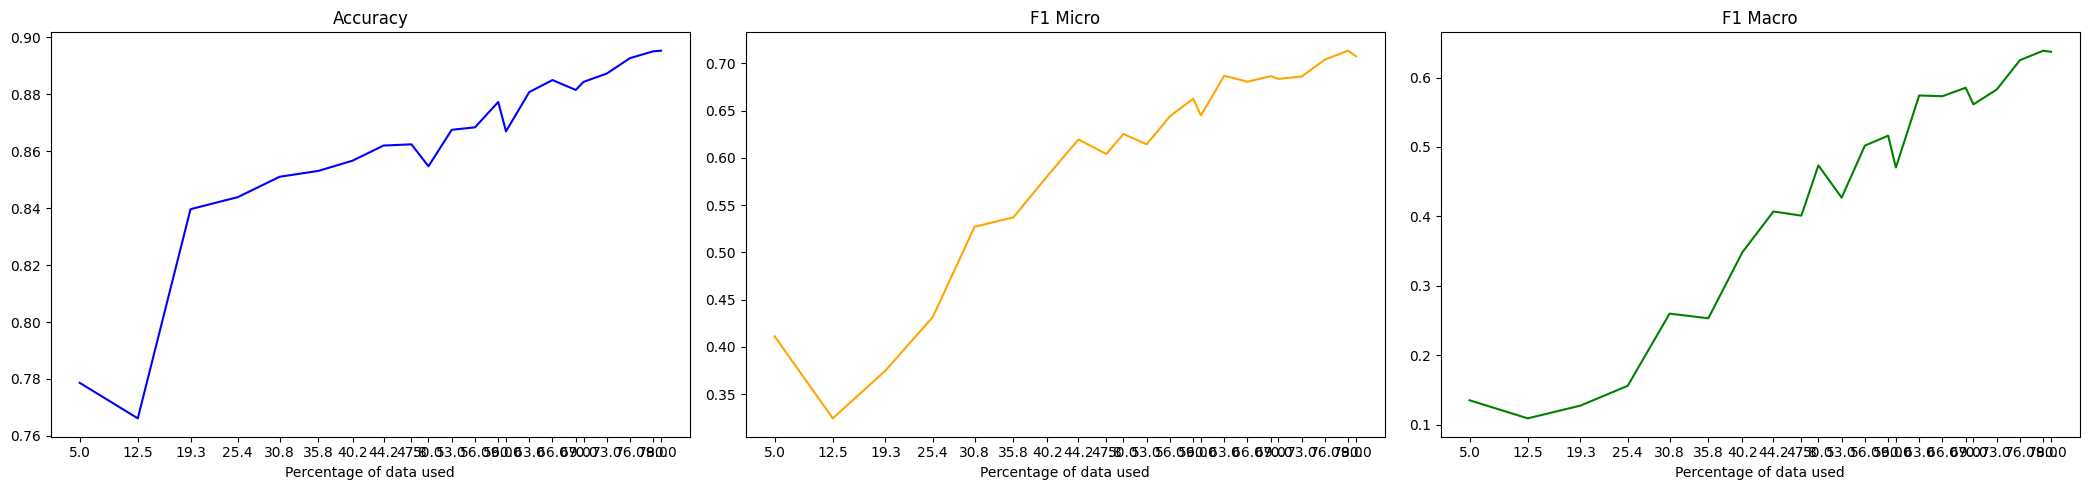

Result saved to results/hsd-lc-1-results.csv


In [27]:
active_learning(42, 0, 'lc')

# MONTE CARLO DROPOUT

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.722, Accuracy: 0.6509, F1 Micro: 0.3623, F1 Macro: 0.1898
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6257, Accuracy: 0.7786, F1 Micro: 0.4111, F1 Macro: 0.135
Epoch 3/10, Train Loss: 0.5647, Accuracy: 0.7998, F1 Micro: 0.4016, F1 Macro: 0.1075
Epoch 4/10, Train Loss: 0.5074, Accuracy: 0.8007, F1 Micro: 0.338, F1 Macro: 0.0861
Epoch 5/10, Train Loss: 0.4635, Accuracy: 0.8061, F1 Micro: 0.2962, F1 Macro: 0.0632
Epoch 6/10, Train Loss: 0.4439, Accuracy: 0.8175, F1 Micro: 0.2737, F1 Macro: 0.0614
Epoch 7/10, Train Loss: 0.4336, Accuracy: 0.8196, F1 Micro: 0.2579, F1 Macro: 0.0613
Epoch 8/10, Train Loss: 0.4161, Accuracy: 0.8205, F1 Micro: 0.2583, F1 Macro: 0.0619
Epoch 9/10, Train Loss: 0.3778, Accuracy: 0.8201, F1 Micro: 0.2366, F1 Macro: 0.0597
Epoch 10/10, Train Loss: 0.3726, Accuracy: 0.8202, F1 Micro: 0.221, F1 Macro: 0.0583
Iteration 166: Accuracy: 0.7786, F1 Micro: 0.4111, F1 Macro: 0.135
               preci

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6769, Accuracy: 0.7714, F1 Micro: 0.4165, F1 Macro: 0.1435
Epoch 2/10, Train Loss: 0.5441, Accuracy: 0.8037, F1 Micro: 0.3725, F1 Macro: 0.1014
Epoch 3/10, Train Loss: 0.4651, Accuracy: 0.8165, F1 Micro: 0.2289, F1 Macro: 0.0568
Epoch 4/10, Train Loss: 0.4375, Accuracy: 0.8135, F1 Micro: 0.1528, F1 Macro: 0.045
Epoch 5/10, Train Loss: 0.4034, Accuracy: 0.82, F1 Micro: 0.223, F1 Macro: 0.0595
Epoch 6/10, Train Loss: 0.3931, Accuracy: 0.8189, F1 Micro: 0.1988, F1 Macro: 0.0569
Epoch 7/10, Train Loss: 0.3721, Accuracy: 0.8281, F1 Micro: 0.2787, F1 Macro: 0.0857
Epoch 8/10, Train Loss: 0.3665, Accuracy: 0.837, F1 Micro: 0.37, F1 Macro: 0.1131
Epoch 9/10, Train Loss: 0.3592, Accuracy: 0.8376, F1 Micro: 0.3622, F1 Macro: 0.1146
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.3431, Accuracy: 0.8458, F1 Micro: 0.4169, F1 Macro: 0.1524
Iteration 416: Accuracy: 0.8458, F1 Micro: 0.4169, F1 Macro: 0.1524
               precisi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6417, Accuracy: 0.7914, F1 Micro: 0.4406, F1 Macro: 0.1269
Epoch 2/10, Train Loss: 0.4961, Accuracy: 0.8189, F1 Micro: 0.3498, F1 Macro: 0.0959
Epoch 3/10, Train Loss: 0.4569, Accuracy: 0.8321, F1 Micro: 0.3734, F1 Macro: 0.1117
Epoch 4/10, Train Loss: 0.4245, Accuracy: 0.8358, F1 Micro: 0.3984, F1 Macro: 0.1176
Epoch 5/10, Train Loss: 0.4203, Accuracy: 0.8396, F1 Micro: 0.4285, F1 Macro: 0.1375
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4038, Accuracy: 0.8443, F1 Micro: 0.4483, F1 Macro: 0.1603
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3813, Accuracy: 0.8474, F1 Micro: 0.4702, F1 Macro: 0.1968
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3428, Accuracy: 0.8579, F1 Micro: 0.5511, F1 Macro: 0.3133
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.319, Accuracy: 0.8658, F1 Micro: 0.5916, F1 Macro: 0.3748
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.3118, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6324, Accuracy: 0.7904, F1 Micro: 0.4393, F1 Macro: 0.1251
Epoch 2/10, Train Loss: 0.4943, Accuracy: 0.8224, F1 Micro: 0.3721, F1 Macro: 0.1045
Epoch 3/10, Train Loss: 0.4472, Accuracy: 0.8248, F1 Micro: 0.4327, F1 Macro: 0.1178
Epoch 4/10, Train Loss: 0.4441, Accuracy: 0.8365, F1 Micro: 0.4175, F1 Macro: 0.1299
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.414, Accuracy: 0.8357, F1 Micro: 0.4624, F1 Macro: 0.1579
Epoch 6/10, Train Loss: 0.3962, Accuracy: 0.8418, F1 Micro: 0.4523, F1 Macro: 0.1757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3658, Accuracy: 0.8536, F1 Micro: 0.5404, F1 Macro: 0.2852
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3441, Accuracy: 0.867, F1 Micro: 0.5804, F1 Macro: 0.3396
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.327, Accuracy: 0.8691, F1 Micro: 0.6212, F1 Macro: 0.4164
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.309, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6092, Accuracy: 0.7938, F1 Micro: 0.4349, F1 Macro: 0.1121
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4821, Accuracy: 0.8222, F1 Micro: 0.4373, F1 Macro: 0.1174
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.445, Accuracy: 0.8267, F1 Micro: 0.4414, F1 Macro: 0.1323
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.429, Accuracy: 0.8356, F1 Micro: 0.4572, F1 Macro: 0.1596
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4095, Accuracy: 0.8449, F1 Micro: 0.4927, F1 Macro: 0.2351
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3748, Accuracy: 0.8567, F1 Micro: 0.5802, F1 Macro: 0.3448
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.359, Accuracy: 0.8684, F1 Micro: 0.6158, F1 Macro: 0.3942
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3305, Accuracy: 0.8733, F1 Micro: 0.6408, F1 Macro: 0.4825
Epoch 9/10, Train Loss: 0.2979, Accuracy: 0.8779, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5986, Accuracy: 0.7944, F1 Micro: 0.4342, F1 Macro: 0.1091
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4783, Accuracy: 0.8147, F1 Micro: 0.4407, F1 Macro: 0.1156
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4539, Accuracy: 0.826, F1 Micro: 0.4431, F1 Macro: 0.1474
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4279, Accuracy: 0.8279, F1 Micro: 0.4431, F1 Macro: 0.1643
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4055, Accuracy: 0.8449, F1 Micro: 0.4858, F1 Macro: 0.2433
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.383, Accuracy: 0.861, F1 Micro: 0.5762, F1 Macro: 0.3662
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3482, Accuracy: 0.8732, F1 Micro: 0.6257, F1 Macro: 0.4314
Epoch 8/10, Train Loss: 0.3157, Accuracy: 0.8742, F1 Micro: 0.6189, F1 Macro: 0.4533
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2915, Accuracy: 0.8813, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5881, Accuracy: 0.7981, F1 Micro: 0.4383, F1 Macro: 0.1099
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4701, Accuracy: 0.8142, F1 Micro: 0.4445, F1 Macro: 0.1159
Epoch 3/10, Train Loss: 0.4417, Accuracy: 0.8274, F1 Micro: 0.4443, F1 Macro: 0.1506
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4223, Accuracy: 0.83, F1 Micro: 0.4816, F1 Macro: 0.2293
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4013, Accuracy: 0.8583, F1 Micro: 0.5629, F1 Macro: 0.3069
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3707, Accuracy: 0.8708, F1 Micro: 0.6107, F1 Macro: 0.3842
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3401, Accuracy: 0.876, F1 Micro: 0.6429, F1 Macro: 0.4772
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3095, Accuracy: 0.8811, F1 Micro: 0.6603, F1 Macro: 0.5579
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2698, Accuracy: 0.8857, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5812, Accuracy: 0.7995, F1 Micro: 0.439, F1 Macro: 0.1097
Epoch 2/10, Train Loss: 0.467, Accuracy: 0.8207, F1 Micro: 0.4373, F1 Macro: 0.117
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4456, Accuracy: 0.8242, F1 Micro: 0.4699, F1 Macro: 0.1684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4157, Accuracy: 0.8453, F1 Micro: 0.5042, F1 Macro: 0.2243
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3841, Accuracy: 0.8663, F1 Micro: 0.5784, F1 Macro: 0.3331
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3617, Accuracy: 0.8728, F1 Micro: 0.6314, F1 Macro: 0.4358
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3251, Accuracy: 0.8796, F1 Micro: 0.6509, F1 Macro: 0.5046
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2926, Accuracy: 0.8841, F1 Micro: 0.6783, F1 Macro: 0.5799
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2612, Accuracy: 0.8859, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5739, Accuracy: 0.805, F1 Micro: 0.4428, F1 Macro: 0.112
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.46, Accuracy: 0.8198, F1 Micro: 0.4439, F1 Macro: 0.1317
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4337, Accuracy: 0.8262, F1 Micro: 0.4551, F1 Macro: 0.1684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4097, Accuracy: 0.8541, F1 Micro: 0.5331, F1 Macro: 0.2795
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3766, Accuracy: 0.8691, F1 Micro: 0.6271, F1 Macro: 0.3972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3473, Accuracy: 0.8743, F1 Micro: 0.6347, F1 Macro: 0.4361
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3119, Accuracy: 0.8809, F1 Micro: 0.6398, F1 Macro: 0.5004
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2751, Accuracy: 0.883, F1 Micro: 0.6518, F1 Macro: 0.521
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.242

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5744, Accuracy: 0.8032, F1 Micro: 0.4422, F1 Macro: 0.1112
Epoch 2/10, Train Loss: 0.4597, Accuracy: 0.819, F1 Micro: 0.4395, F1 Macro: 0.1367
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4253, Accuracy: 0.8263, F1 Micro: 0.4669, F1 Macro: 0.1903
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4086, Accuracy: 0.8462, F1 Micro: 0.5303, F1 Macro: 0.2769
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3854, Accuracy: 0.8696, F1 Micro: 0.6142, F1 Macro: 0.4077
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3444, Accuracy: 0.8754, F1 Micro: 0.6325, F1 Macro: 0.4666
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3166, Accuracy: 0.8837, F1 Micro: 0.6838, F1 Macro: 0.5709
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2796, Accuracy: 0.889, F1 Micro: 0.6949, F1 Macro: 0.6221
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2556, Accuracy: 0.8906, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5638, Accuracy: 0.8192, F1 Micro: 0.4239, F1 Macro: 0.1138
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4608, Accuracy: 0.824, F1 Micro: 0.4411, F1 Macro: 0.1397
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4292, Accuracy: 0.8298, F1 Micro: 0.4803, F1 Macro: 0.2265
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4001, Accuracy: 0.856, F1 Micro: 0.5599, F1 Macro: 0.3069
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3637, Accuracy: 0.8725, F1 Micro: 0.624, F1 Macro: 0.4133
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3351, Accuracy: 0.8786, F1 Micro: 0.6444, F1 Macro: 0.4704
Epoch 7/10, Train Loss: 0.2959, Accuracy: 0.8819, F1 Micro: 0.6421, F1 Macro: 0.5038
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2698, Accuracy: 0.8836, F1 Micro: 0.6513, F1 Macro: 0.5554
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2399, Accuracy: 0.8934, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5609, Accuracy: 0.8219, F1 Micro: 0.4031, F1 Macro: 0.1119
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4525, Accuracy: 0.8268, F1 Micro: 0.4451, F1 Macro: 0.148
Epoch 3/10, Train Loss: 0.4169, Accuracy: 0.8401, F1 Micro: 0.4395, F1 Macro: 0.174
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3862, Accuracy: 0.8653, F1 Micro: 0.5728, F1 Macro: 0.3233
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3553, Accuracy: 0.8732, F1 Micro: 0.6049, F1 Macro: 0.4209
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3157, Accuracy: 0.8812, F1 Micro: 0.6536, F1 Macro: 0.5228
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2831, Accuracy: 0.8905, F1 Micro: 0.7083, F1 Macro: 0.6084
Epoch 8/10, Train Loss: 0.2576, Accuracy: 0.893, F1 Micro: 0.7069, F1 Macro: 0.6202
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2231, Accuracy: 0.8969, F1 Micro: 0.7184, F1 Macro: 0.6362
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5502, Accuracy: 0.8237, F1 Micro: 0.3704, F1 Macro: 0.1069
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4452, Accuracy: 0.8254, F1 Micro: 0.4488, F1 Macro: 0.15
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4083, Accuracy: 0.8492, F1 Micro: 0.5011, F1 Macro: 0.2399
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3808, Accuracy: 0.869, F1 Micro: 0.589, F1 Macro: 0.3677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.333, Accuracy: 0.8757, F1 Micro: 0.618, F1 Macro: 0.4303
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3021, Accuracy: 0.8827, F1 Micro: 0.645, F1 Macro: 0.5118
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2681, Accuracy: 0.8914, F1 Micro: 0.6849, F1 Macro: 0.5915
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2314, Accuracy: 0.8925, F1 Micro: 0.7036, F1 Macro: 0.6166
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2076

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5494, Accuracy: 0.8241, F1 Micro: 0.3665, F1 Macro: 0.1068
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4434, Accuracy: 0.8286, F1 Micro: 0.4381, F1 Macro: 0.1519
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4142, Accuracy: 0.8461, F1 Micro: 0.491, F1 Macro: 0.2446
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3815, Accuracy: 0.871, F1 Micro: 0.6116, F1 Macro: 0.3759
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.339, Accuracy: 0.8751, F1 Micro: 0.6442, F1 Macro: 0.4814
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2982, Accuracy: 0.8817, F1 Micro: 0.6663, F1 Macro: 0.5408
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2653, Accuracy: 0.8886, F1 Micro: 0.6782, F1 Macro: 0.5925
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2349, Accuracy: 0.892, F1 Micro: 0.7015, F1 Macro: 0.6149
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5448, Accuracy: 0.8245, F1 Micro: 0.4143, F1 Macro: 0.1147
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.441, Accuracy: 0.829, F1 Micro: 0.4359, F1 Macro: 0.1447
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.403, Accuracy: 0.8507, F1 Micro: 0.4881, F1 Macro: 0.2397
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3603, Accuracy: 0.8666, F1 Micro: 0.5704, F1 Macro: 0.3734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3223, Accuracy: 0.8778, F1 Micro: 0.6361, F1 Macro: 0.4719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2899, Accuracy: 0.8825, F1 Micro: 0.6537, F1 Macro: 0.525
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2611, Accuracy: 0.8892, F1 Micro: 0.6852, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2266, Accuracy: 0.8927, F1 Micro: 0.7054, F1 Macro: 0.6229
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5352, Accuracy: 0.8298, F1 Micro: 0.3761, F1 Macro: 0.1109
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4274, Accuracy: 0.835, F1 Micro: 0.4318, F1 Macro: 0.1524
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3866, Accuracy: 0.8631, F1 Micro: 0.5779, F1 Macro: 0.3283
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3449, Accuracy: 0.873, F1 Micro: 0.6058, F1 Macro: 0.4217
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3069, Accuracy: 0.878, F1 Micro: 0.6463, F1 Macro: 0.474
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2683, Accuracy: 0.8852, F1 Micro: 0.6574, F1 Macro: 0.5274
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2417, Accuracy: 0.8894, F1 Micro: 0.6778, F1 Macro: 0.5876
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2049, Accuracy: 0.8937, F1 Micro: 0.7057, F1 Macro: 0.6215
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5313, Accuracy: 0.8224, F1 Micro: 0.2804, F1 Macro: 0.0772
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4254, Accuracy: 0.8354, F1 Micro: 0.4109, F1 Macro: 0.1431
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3811, Accuracy: 0.8576, F1 Micro: 0.5264, F1 Macro: 0.2961
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3431, Accuracy: 0.8724, F1 Micro: 0.6174, F1 Macro: 0.4344
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2915, Accuracy: 0.8798, F1 Micro: 0.6696, F1 Macro: 0.5385
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2674, Accuracy: 0.8854, F1 Micro: 0.6927, F1 Macro: 0.5945
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2375, Accuracy: 0.8926, F1 Micro: 0.7011, F1 Macro: 0.6287
Epoch 8/10, Train Loss: 0.2111, Accuracy: 0.8925, F1 Micro: 0.698, F1 Macro: 0.613
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1805, Accuracy: 0.8979, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.525, Accuracy: 0.8289, F1 Micro: 0.374, F1 Macro: 0.1102
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4191, Accuracy: 0.84, F1 Micro: 0.4232, F1 Macro: 0.1549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3735, Accuracy: 0.8647, F1 Micro: 0.5681, F1 Macro: 0.3176
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3207, Accuracy: 0.8708, F1 Micro: 0.6519, F1 Macro: 0.4867
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2872, Accuracy: 0.8814, F1 Micro: 0.665, F1 Macro: 0.5235
Epoch 6/10, Train Loss: 0.2523, Accuracy: 0.8774, F1 Micro: 0.6082, F1 Macro: 0.4641
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2253, Accuracy: 0.8929, F1 Micro: 0.7086, F1 Macro: 0.6198
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1987, Accuracy: 0.8955, F1 Micro: 0.7188, F1 Macro: 0.6449
Epoch 9/10, Train Loss: 0.1682, Accuracy: 0.8956, F1 Micro: 0.7132, F1 Macro: 0.6391
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.521, Accuracy: 0.8247, F1 Micro: 0.2811, F1 Macro: 0.0816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4139, Accuracy: 0.837, F1 Micro: 0.3652, F1 Macro: 0.1261
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3697, Accuracy: 0.859, F1 Micro: 0.5137, F1 Macro: 0.252
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3182, Accuracy: 0.8738, F1 Micro: 0.6223, F1 Macro: 0.4328
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2876, Accuracy: 0.8802, F1 Micro: 0.6452, F1 Macro: 0.4783
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2627, Accuracy: 0.8868, F1 Micro: 0.6886, F1 Macro: 0.5851
Epoch 7/10, Train Loss: 0.2185, Accuracy: 0.8896, F1 Micro: 0.685, F1 Macro: 0.5757
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2036, Accuracy: 0.8914, F1 Micro: 0.7076, F1 Macro: 0.6383
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1734, Accuracy: 0.9006, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5195, Accuracy: 0.83, F1 Micro: 0.3219, F1 Macro: 0.0996
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4052, Accuracy: 0.8464, F1 Micro: 0.4425, F1 Macro: 0.17
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3496, Accuracy: 0.8678, F1 Micro: 0.6086, F1 Macro: 0.3632
Epoch 4/10, Train Loss: 0.3062, Accuracy: 0.8754, F1 Micro: 0.6066, F1 Macro: 0.4112
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2653, Accuracy: 0.8799, F1 Micro: 0.6675, F1 Macro: 0.5299
Epoch 6/10, Train Loss: 0.2397, Accuracy: 0.8841, F1 Micro: 0.6605, F1 Macro: 0.5427
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2082, Accuracy: 0.8903, F1 Micro: 0.6988, F1 Macro: 0.5993
Epoch 8/10, Train Loss: 0.1917, Accuracy: 0.8927, F1 Micro: 0.6952, F1 Macro: 0.6101
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1663, Accuracy: 0.8974, F1 Micro: 0.7077, F1 Macro: 0.6344
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5073, Accuracy: 0.8211, F1 Micro: 0.2203, F1 Macro: 0.0704
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3874, Accuracy: 0.8462, F1 Micro: 0.4289, F1 Macro: 0.1569
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3415, Accuracy: 0.8694, F1 Micro: 0.6081, F1 Macro: 0.376
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2913, Accuracy: 0.8764, F1 Micro: 0.6481, F1 Macro: 0.4553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2535, Accuracy: 0.8824, F1 Micro: 0.6661, F1 Macro: 0.5052
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2221, Accuracy: 0.8873, F1 Micro: 0.6723, F1 Macro: 0.531
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1939, Accuracy: 0.8878, F1 Micro: 0.6793, F1 Macro: 0.575
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1655, Accuracy: 0.8954, F1 Micro: 0.7073, F1 Macro: 0.6289
Epoch 9/10, Train Loss: 0.1475, Accuracy: 0.894, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5123, Accuracy: 0.8251, F1 Micro: 0.2659, F1 Macro: 0.0857
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3962, Accuracy: 0.8387, F1 Micro: 0.3648, F1 Macro: 0.1232
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3393, Accuracy: 0.8681, F1 Micro: 0.5715, F1 Macro: 0.3636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2879, Accuracy: 0.8764, F1 Micro: 0.6392, F1 Macro: 0.4393
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2513, Accuracy: 0.8821, F1 Micro: 0.6815, F1 Macro: 0.5518
Epoch 6/10, Train Loss: 0.2264, Accuracy: 0.8849, F1 Micro: 0.6756, F1 Macro: 0.5417
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2023, Accuracy: 0.89, F1 Micro: 0.6878, F1 Macro: 0.6044
Epoch 8/10, Train Loss: 0.1703, Accuracy: 0.8926, F1 Micro: 0.6861, F1 Macro: 0.5911
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1464, Accuracy: 0.8979, F1 Micro: 0.71, F1 Macro: 0.6209
Higher F

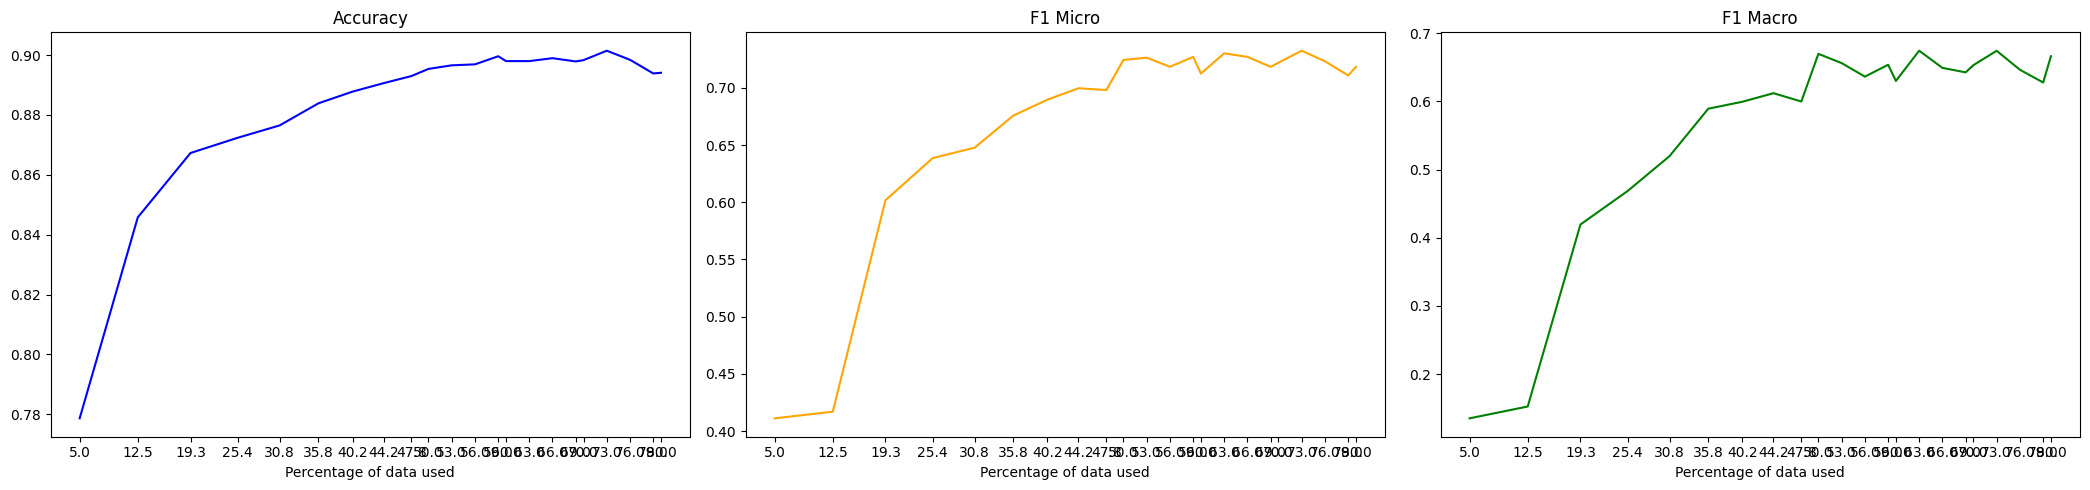

Result saved to results/hsd-mc-1-results.csv


In [28]:
active_learning(42, 0, 'mc')

# KMEANS

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.722, Accuracy: 0.6509, F1 Micro: 0.3623, F1 Macro: 0.1898
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6257, Accuracy: 0.7786, F1 Micro: 0.4111, F1 Macro: 0.135
Epoch 3/10, Train Loss: 0.5647, Accuracy: 0.7998, F1 Micro: 0.4016, F1 Macro: 0.1075
Epoch 4/10, Train Loss: 0.5074, Accuracy: 0.8007, F1 Micro: 0.338, F1 Macro: 0.0861
Epoch 5/10, Train Loss: 0.4635, Accuracy: 0.8061, F1 Micro: 0.2962, F1 Macro: 0.0632
Epoch 6/10, Train Loss: 0.4439, Accuracy: 0.8175, F1 Micro: 0.2737, F1 Macro: 0.0614
Epoch 7/10, Train Loss: 0.4336, Accuracy: 0.8196, F1 Micro: 0.2579, F1 Macro: 0.0613
Epoch 8/10, Train Loss: 0.4161, Accuracy: 0.8205, F1 Micro: 0.2583, F1 Macro: 0.0619
Epoch 9/10, Train Loss: 0.3778, Accuracy: 0.8201, F1 Micro: 0.2366, F1 Macro: 0.0597
Epoch 10/10, Train Loss: 0.3726, Accuracy: 0.8202, F1 Micro: 0.221, F1 Macro: 0.0583
Iteration 166: Accuracy: 0.7786, F1 Micro: 0.4111, F1 Macro: 0.135
               preci

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6806, Accuracy: 0.7706, F1 Micro: 0.384, F1 Macro: 0.1284
Epoch 2/10, Train Loss: 0.5399, Accuracy: 0.8001, F1 Micro: 0.2975, F1 Macro: 0.0647
Epoch 3/10, Train Loss: 0.4608, Accuracy: 0.8103, F1 Micro: 0.1073, F1 Macro: 0.0348
Epoch 4/10, Train Loss: 0.4073, Accuracy: 0.8031, F1 Micro: 0.0055, F1 Macro: 0.0023
Epoch 5/10, Train Loss: 0.3858, Accuracy: 0.8033, F1 Micro: 0.0077, F1 Macro: 0.0031
Epoch 6/10, Train Loss: 0.3611, Accuracy: 0.8035, F1 Micro: 0.0098, F1 Macro: 0.004
Epoch 7/10, Train Loss: 0.3515, Accuracy: 0.8081, F1 Micro: 0.0625, F1 Macro: 0.0228
Epoch 8/10, Train Loss: 0.3397, Accuracy: 0.8183, F1 Micro: 0.1671, F1 Macro: 0.0513
Epoch 9/10, Train Loss: 0.3571, Accuracy: 0.8238, F1 Micro: 0.2222, F1 Macro: 0.0691
Epoch 10/10, Train Loss: 0.3377, Accuracy: 0.8331, F1 Micro: 0.3022, F1 Macro: 0.0959
Iteration 416: Accuracy: 0.7706, F1 Micro: 0.384, F1 Macro: 0.1284
               precision    recall  f1-score   supp

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6401, Accuracy: 0.796, F1 Micro: 0.3286, F1 Macro: 0.0834
Epoch 2/10, Train Loss: 0.4683, Accuracy: 0.8053, F1 Micro: 0.0386, F1 Macro: 0.0146
Epoch 3/10, Train Loss: 0.3994, Accuracy: 0.8026, F1 Micro: 0.0011, F1 Macro: 0.0005
Epoch 4/10, Train Loss: 0.3847, Accuracy: 0.8026, F1 Micro: 0.0011, F1 Macro: 0.0005
Epoch 5/10, Train Loss: 0.3631, Accuracy: 0.8066, F1 Micro: 0.046, F1 Macro: 0.0174
Epoch 6/10, Train Loss: 0.365, Accuracy: 0.8149, F1 Micro: 0.134, F1 Macro: 0.0427
Epoch 7/10, Train Loss: 0.3374, Accuracy: 0.8232, F1 Micro: 0.2157, F1 Macro: 0.0657
Epoch 8/10, Train Loss: 0.3071, Accuracy: 0.836, F1 Micro: 0.3251, F1 Macro: 0.102
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3045, Accuracy: 0.841, F1 Micro: 0.3704, F1 Macro: 0.1319
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2893, Accuracy: 0.8494, F1 Micro: 0.4645, F1 Macro: 0.1962
Iteration 641: Accuracy: 0.8494, F1 Micro: 0.4645, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6283, Accuracy: 0.7988, F1 Micro: 0.3229, F1 Macro: 0.0796
Epoch 2/10, Train Loss: 0.4427, Accuracy: 0.8034, F1 Micro: 0.0098, F1 Macro: 0.004
Epoch 3/10, Train Loss: 0.3851, Accuracy: 0.8038, F1 Micro: 0.0131, F1 Macro: 0.0053
Epoch 4/10, Train Loss: 0.3702, Accuracy: 0.8056, F1 Micro: 0.0314, F1 Macro: 0.0122
Epoch 5/10, Train Loss: 0.3423, Accuracy: 0.8164, F1 Micro: 0.159, F1 Macro: 0.0488
Epoch 6/10, Train Loss: 0.3557, Accuracy: 0.8249, F1 Micro: 0.2365, F1 Macro: 0.0718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3253, Accuracy: 0.8375, F1 Micro: 0.3447, F1 Macro: 0.1101
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3015, Accuracy: 0.8497, F1 Micro: 0.4381, F1 Macro: 0.1671
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2845, Accuracy: 0.8567, F1 Micro: 0.5222, F1 Macro: 0.2516
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2582, Accuracy: 0.8594, F1 Micro: 0.5512, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5984, Accuracy: 0.8045, F1 Micro: 0.29, F1 Macro: 0.0598
Epoch 2/10, Train Loss: 0.4166, Accuracy: 0.8046, F1 Micro: 0.0228, F1 Macro: 0.009
Epoch 3/10, Train Loss: 0.3844, Accuracy: 0.8054, F1 Micro: 0.0313, F1 Macro: 0.0122
Epoch 4/10, Train Loss: 0.3644, Accuracy: 0.8159, F1 Micro: 0.1561, F1 Macro: 0.0478
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3494, Accuracy: 0.8342, F1 Micro: 0.3209, F1 Macro: 0.1
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3201, Accuracy: 0.8451, F1 Micro: 0.4065, F1 Macro: 0.1485
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3031, Accuracy: 0.8567, F1 Micro: 0.526, F1 Macro: 0.2435
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2634, Accuracy: 0.8656, F1 Micro: 0.5968, F1 Macro: 0.3568
Epoch 9/10, Train Loss: 0.2336, Accuracy: 0.8662, F1 Micro: 0.5761, F1 Macro: 0.3623
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2123, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5815, Accuracy: 0.8152, F1 Micro: 0.2805, F1 Macro: 0.063
Epoch 2/10, Train Loss: 0.4095, Accuracy: 0.806, F1 Micro: 0.0387, F1 Macro: 0.0148
Epoch 3/10, Train Loss: 0.3783, Accuracy: 0.8108, F1 Micro: 0.0917, F1 Macro: 0.0315
Epoch 4/10, Train Loss: 0.3624, Accuracy: 0.8222, F1 Micro: 0.2169, F1 Macro: 0.0641
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3436, Accuracy: 0.8414, F1 Micro: 0.3741, F1 Macro: 0.1238
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.321, Accuracy: 0.8458, F1 Micro: 0.4174, F1 Macro: 0.1733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2838, Accuracy: 0.8529, F1 Micro: 0.4848, F1 Macro: 0.2846
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2643, Accuracy: 0.8686, F1 Micro: 0.6207, F1 Macro: 0.3966
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2354, Accuracy: 0.8716, F1 Micro: 0.626, F1 Macro: 0.4157
Epoch 10/10, Train Loss: 0.2031, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5693, Accuracy: 0.8171, F1 Micro: 0.2085, F1 Macro: 0.0551
Epoch 2/10, Train Loss: 0.4083, Accuracy: 0.8074, F1 Micro: 0.0564, F1 Macro: 0.0207
Epoch 3/10, Train Loss: 0.3783, Accuracy: 0.8169, F1 Micro: 0.1686, F1 Macro: 0.0516
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3536, Accuracy: 0.8307, F1 Micro: 0.287, F1 Macro: 0.0921
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3417, Accuracy: 0.8487, F1 Micro: 0.4315, F1 Macro: 0.1627
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3106, Accuracy: 0.8561, F1 Micro: 0.5015, F1 Macro: 0.2571
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2688, Accuracy: 0.8677, F1 Micro: 0.5952, F1 Macro: 0.3746
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2404, Accuracy: 0.8712, F1 Micro: 0.6031, F1 Macro: 0.4077
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2211, Accuracy: 0.875, F1 Micro: 0.6584, F1 Macro: 0.5128
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5641, Accuracy: 0.8113, F1 Micro: 0.1248, F1 Macro: 0.0389
Epoch 2/10, Train Loss: 0.4034, Accuracy: 0.8085, F1 Micro: 0.0725, F1 Macro: 0.0257
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3788, Accuracy: 0.8204, F1 Micro: 0.2001, F1 Macro: 0.0621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3603, Accuracy: 0.8445, F1 Micro: 0.4177, F1 Macro: 0.1319
Epoch 5/10, Train Loss: 0.325, Accuracy: 0.8438, F1 Micro: 0.4132, F1 Macro: 0.1741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.294, Accuracy: 0.8661, F1 Micro: 0.6006, F1 Macro: 0.3657
Epoch 7/10, Train Loss: 0.2598, Accuracy: 0.8666, F1 Micro: 0.5781, F1 Macro: 0.3671
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2317, Accuracy: 0.8737, F1 Micro: 0.6169, F1 Macro: 0.4239
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2119, Accuracy: 0.8773, F1 Micro: 0.6502, F1 Macro: 0.5058
Epoch 10/10, Train Loss: 0.1873, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5546, Accuracy: 0.8067, F1 Micro: 0.0542, F1 Macro: 0.0199
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3918, Accuracy: 0.8121, F1 Micro: 0.1172, F1 Macro: 0.0378
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3795, Accuracy: 0.8248, F1 Micro: 0.2357, F1 Macro: 0.0766
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3508, Accuracy: 0.8473, F1 Micro: 0.4264, F1 Macro: 0.154
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3156, Accuracy: 0.8623, F1 Micro: 0.5598, F1 Macro: 0.3254
Epoch 6/10, Train Loss: 0.2792, Accuracy: 0.8549, F1 Micro: 0.5065, F1 Macro: 0.3212
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2524, Accuracy: 0.8726, F1 Micro: 0.6176, F1 Macro: 0.4224
Epoch 8/10, Train Loss: 0.216, Accuracy: 0.8664, F1 Micro: 0.5751, F1 Macro: 0.3947
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2074, Accuracy: 0.874, F1 Micro: 0.6494, F1 Macro: 0.5316
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5537, Accuracy: 0.8082, F1 Micro: 0.0714, F1 Macro: 0.0252
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4094, Accuracy: 0.8111, F1 Micro: 0.1021, F1 Macro: 0.0341
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3799, Accuracy: 0.8281, F1 Micro: 0.2754, F1 Macro: 0.0855
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3538, Accuracy: 0.8406, F1 Micro: 0.3665, F1 Macro: 0.1295
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3264, Accuracy: 0.8598, F1 Micro: 0.5309, F1 Macro: 0.283
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2888, Accuracy: 0.871, F1 Micro: 0.6126, F1 Macro: 0.3789
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2591, Accuracy: 0.8761, F1 Micro: 0.6527, F1 Macro: 0.4478
Epoch 8/10, Train Loss: 0.2284, Accuracy: 0.8775, F1 Micro: 0.6392, F1 Macro: 0.4516
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2033, Accuracy: 0.8788, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5422, Accuracy: 0.8066, F1 Micro: 0.0561, F1 Macro: 0.0204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4011, Accuracy: 0.8109, F1 Micro: 0.1029, F1 Macro: 0.0342
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3744, Accuracy: 0.8293, F1 Micro: 0.2853, F1 Macro: 0.0916
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3518, Accuracy: 0.8518, F1 Micro: 0.4652, F1 Macro: 0.1845
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3003, Accuracy: 0.8666, F1 Micro: 0.5849, F1 Macro: 0.3537
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2709, Accuracy: 0.8735, F1 Micro: 0.6401, F1 Macro: 0.4241
Epoch 7/10, Train Loss: 0.2385, Accuracy: 0.8732, F1 Micro: 0.6183, F1 Macro: 0.426
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.212, Accuracy: 0.881, F1 Micro: 0.6521, F1 Macro: 0.4923
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1982, Accuracy: 0.8805, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5394, Accuracy: 0.8063, F1 Micro: 0.052, F1 Macro: 0.0191
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3973, Accuracy: 0.8136, F1 Micro: 0.1393, F1 Macro: 0.0437
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3596, Accuracy: 0.8385, F1 Micro: 0.3586, F1 Macro: 0.1126
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.332, Accuracy: 0.8584, F1 Micro: 0.5111, F1 Macro: 0.2403
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3055, Accuracy: 0.873, F1 Micro: 0.6252, F1 Macro: 0.3977
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2677, Accuracy: 0.8757, F1 Micro: 0.6478, F1 Macro: 0.4467
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2332, Accuracy: 0.8796, F1 Micro: 0.6663, F1 Macro: 0.4869
Epoch 8/10, Train Loss: 0.214, Accuracy: 0.8766, F1 Micro: 0.6194, F1 Macro: 0.4521
Epoch 9/10, Train Loss: 0.188, Accuracy: 0.883, F1 Micro: 0.6627, F1 Macro: 0.5369
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5282, Accuracy: 0.8057, F1 Micro: 0.0386, F1 Macro: 0.0147
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.401, Accuracy: 0.8207, F1 Micro: 0.2111, F1 Macro: 0.0641
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3653, Accuracy: 0.8423, F1 Micro: 0.3938, F1 Macro: 0.1324
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3287, Accuracy: 0.8662, F1 Micro: 0.5883, F1 Macro: 0.345
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2928, Accuracy: 0.872, F1 Micro: 0.6106, F1 Macro: 0.3926
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2476, Accuracy: 0.876, F1 Micro: 0.6467, F1 Macro: 0.4671
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2266, Accuracy: 0.8803, F1 Micro: 0.6611, F1 Macro: 0.5273
Epoch 8/10, Train Loss: 0.1982, Accuracy: 0.8751, F1 Micro: 0.6105, F1 Macro: 0.4557
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1771, Accuracy: 0.8854, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5285, Accuracy: 0.8078, F1 Micro: 0.0694, F1 Macro: 0.0246
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3947, Accuracy: 0.8168, F1 Micro: 0.1709, F1 Macro: 0.0507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3663, Accuracy: 0.8431, F1 Micro: 0.4059, F1 Macro: 0.1381
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3295, Accuracy: 0.8626, F1 Micro: 0.5482, F1 Macro: 0.3284
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.281, Accuracy: 0.8719, F1 Micro: 0.6044, F1 Macro: 0.3899
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2675, Accuracy: 0.8752, F1 Micro: 0.608, F1 Macro: 0.4281
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2288, Accuracy: 0.8801, F1 Micro: 0.6591, F1 Macro: 0.4785
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2026, Accuracy: 0.8831, F1 Micro: 0.6816, F1 Macro: 0.5743
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5271, Accuracy: 0.8063, F1 Micro: 0.0449, F1 Macro: 0.0169
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3999, Accuracy: 0.8218, F1 Micro: 0.2262, F1 Macro: 0.0659
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3622, Accuracy: 0.8416, F1 Micro: 0.386, F1 Macro: 0.133
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.318, Accuracy: 0.8585, F1 Micro: 0.516, F1 Macro: 0.3106
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2855, Accuracy: 0.869, F1 Micro: 0.5694, F1 Macro: 0.3664
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2523, Accuracy: 0.8761, F1 Micro: 0.6268, F1 Macro: 0.4316
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2267, Accuracy: 0.8826, F1 Micro: 0.6591, F1 Macro: 0.5169
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1941, Accuracy: 0.8837, F1 Micro: 0.6652, F1 Macro: 0.5586
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.17

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.52, Accuracy: 0.8112, F1 Micro: 0.1086, F1 Macro: 0.0357
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3916, Accuracy: 0.826, F1 Micro: 0.2581, F1 Macro: 0.084
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3463, Accuracy: 0.8534, F1 Micro: 0.4687, F1 Macro: 0.2019
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3095, Accuracy: 0.8702, F1 Micro: 0.5968, F1 Macro: 0.3671
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2706, Accuracy: 0.8752, F1 Micro: 0.6244, F1 Macro: 0.4188
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2437, Accuracy: 0.879, F1 Micro: 0.6479, F1 Macro: 0.4653
Epoch 7/10, Train Loss: 0.2152, Accuracy: 0.8792, F1 Micro: 0.6415, F1 Macro: 0.5239
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.184, Accuracy: 0.8866, F1 Micro: 0.6731, F1 Macro: 0.5768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1649, Accuracy: 0.8916, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5235, Accuracy: 0.8111, F1 Micro: 0.1067, F1 Macro: 0.0351
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3917, Accuracy: 0.8285, F1 Micro: 0.2849, F1 Macro: 0.0907
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3533, Accuracy: 0.8598, F1 Micro: 0.5322, F1 Macro: 0.2286
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3104, Accuracy: 0.8713, F1 Micro: 0.6062, F1 Macro: 0.3696
Epoch 5/10, Train Loss: 0.2782, Accuracy: 0.8737, F1 Micro: 0.5961, F1 Macro: 0.3962
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.246, Accuracy: 0.8768, F1 Micro: 0.6114, F1 Macro: 0.4233
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2209, Accuracy: 0.8778, F1 Micro: 0.6224, F1 Macro: 0.4889
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.187, Accuracy: 0.8857, F1 Micro: 0.6637, F1 Macro: 0.563
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1662, Accuracy: 0.8892, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5166, Accuracy: 0.8111, F1 Micro: 0.1113, F1 Macro: 0.0362
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3901, Accuracy: 0.8324, F1 Micro: 0.3179, F1 Macro: 0.1004
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3496, Accuracy: 0.8519, F1 Micro: 0.4666, F1 Macro: 0.2239
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3119, Accuracy: 0.8709, F1 Micro: 0.6295, F1 Macro: 0.4047
Epoch 5/10, Train Loss: 0.2754, Accuracy: 0.875, F1 Micro: 0.6145, F1 Macro: 0.412
Epoch 6/10, Train Loss: 0.234, Accuracy: 0.877, F1 Micro: 0.6184, F1 Macro: 0.4577
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2077, Accuracy: 0.8826, F1 Micro: 0.6521, F1 Macro: 0.5104
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1875, Accuracy: 0.8895, F1 Micro: 0.6967, F1 Macro: 0.6109
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1615, Accuracy: 0.8916, F1 Micro: 0.6981, F1 Macro: 0.5821
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5136, Accuracy: 0.8112, F1 Micro: 0.1095, F1 Macro: 0.0359
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.396, Accuracy: 0.8309, F1 Micro: 0.3094, F1 Macro: 0.0957
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3494, Accuracy: 0.8547, F1 Micro: 0.4852, F1 Macro: 0.2317
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3065, Accuracy: 0.8722, F1 Micro: 0.6099, F1 Macro: 0.3794
Epoch 5/10, Train Loss: 0.2633, Accuracy: 0.8732, F1 Micro: 0.6006, F1 Macro: 0.4014
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2443, Accuracy: 0.8808, F1 Micro: 0.6567, F1 Macro: 0.4869
Epoch 7/10, Train Loss: 0.209, Accuracy: 0.8839, F1 Micro: 0.6512, F1 Macro: 0.5125
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1866, Accuracy: 0.8867, F1 Micro: 0.6719, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1614, Accuracy: 0.8929, F1 Micro: 0.7074, F1 Macro: 0.6088
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5151, Accuracy: 0.8196, F1 Micro: 0.2174, F1 Macro: 0.0648
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3917, Accuracy: 0.8324, F1 Micro: 0.3075, F1 Macro: 0.0984
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3473, Accuracy: 0.8581, F1 Micro: 0.5152, F1 Macro: 0.2526
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3078, Accuracy: 0.8751, F1 Micro: 0.6286, F1 Macro: 0.4039
Epoch 5/10, Train Loss: 0.2577, Accuracy: 0.8751, F1 Micro: 0.6097, F1 Macro: 0.4402
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2341, Accuracy: 0.8823, F1 Micro: 0.6834, F1 Macro: 0.5685
Epoch 7/10, Train Loss: 0.2067, Accuracy: 0.8891, F1 Micro: 0.6812, F1 Macro: 0.5866
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1806, Accuracy: 0.8914, F1 Micro: 0.7015, F1 Macro: 0.6121
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1563, Accuracy: 0.8924, F1 Micro: 0.7065, F1 Macro: 0.6314
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5078, Accuracy: 0.819, F1 Micro: 0.2117, F1 Macro: 0.063
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3854, Accuracy: 0.8434, F1 Micro: 0.4088, F1 Macro: 0.1352
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3396, Accuracy: 0.8689, F1 Micro: 0.5927, F1 Macro: 0.3462
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2913, Accuracy: 0.8736, F1 Micro: 0.6041, F1 Macro: 0.3958
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2515, Accuracy: 0.8808, F1 Micro: 0.6746, F1 Macro: 0.5075
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2287, Accuracy: 0.887, F1 Micro: 0.6955, F1 Macro: 0.5805
Epoch 7/10, Train Loss: 0.2013, Accuracy: 0.8905, F1 Micro: 0.6921, F1 Macro: 0.5871
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.176, Accuracy: 0.893, F1 Micro: 0.7102, F1 Macro: 0.6229
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1525, Accuracy: 0.8974, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5029, Accuracy: 0.8133, F1 Micro: 0.1321, F1 Macro: 0.0431
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3933, Accuracy: 0.8432, F1 Micro: 0.3987, F1 Macro: 0.1387
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3303, Accuracy: 0.8646, F1 Micro: 0.552, F1 Macro: 0.3326
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2852, Accuracy: 0.8764, F1 Micro: 0.6187, F1 Macro: 0.4195
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2523, Accuracy: 0.8759, F1 Micro: 0.6291, F1 Macro: 0.4858
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.228, Accuracy: 0.8868, F1 Micro: 0.6702, F1 Macro: 0.5609
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1919, Accuracy: 0.887, F1 Micro: 0.675, F1 Macro: 0.5722
Epoch 8/10, Train Loss: 0.1731, Accuracy: 0.8892, F1 Micro: 0.6675, F1 Macro: 0.5505
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1525, Accuracy: 0.8982, F1 Micro: 

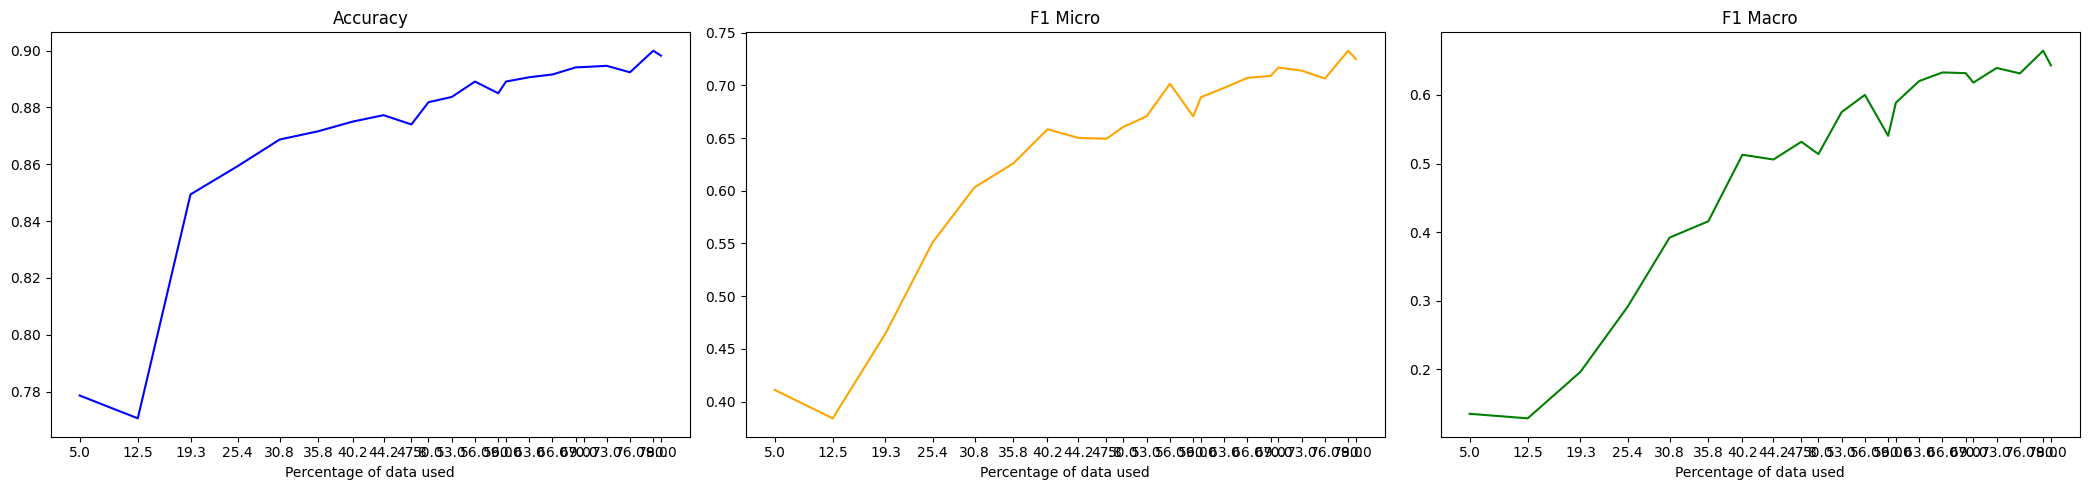

Result saved to results/hsd-kmeans-1-results.csv


In [29]:
active_learning(42, 0, 'kmeans')

# CORESET

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.722, Accuracy: 0.6509, F1 Micro: 0.3623, F1 Macro: 0.1898
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6257, Accuracy: 0.7786, F1 Micro: 0.4111, F1 Macro: 0.135
Epoch 3/10, Train Loss: 0.5647, Accuracy: 0.7998, F1 Micro: 0.4016, F1 Macro: 0.1075
Epoch 4/10, Train Loss: 0.5074, Accuracy: 0.8007, F1 Micro: 0.338, F1 Macro: 0.0861
Epoch 5/10, Train Loss: 0.4635, Accuracy: 0.8061, F1 Micro: 0.2962, F1 Macro: 0.0632
Epoch 6/10, Train Loss: 0.4439, Accuracy: 0.8175, F1 Micro: 0.2737, F1 Macro: 0.0614
Epoch 7/10, Train Loss: 0.4336, Accuracy: 0.8196, F1 Micro: 0.2579, F1 Macro: 0.0613
Epoch 8/10, Train Loss: 0.4161, Accuracy: 0.8205, F1 Micro: 0.2583, F1 Macro: 0.0619
Epoch 9/10, Train Loss: 0.3778, Accuracy: 0.8201, F1 Micro: 0.2366, F1 Macro: 0.0597
Epoch 10/10, Train Loss: 0.3726, Accuracy: 0.8202, F1 Micro: 0.221, F1 Macro: 0.0583
Iteration 166: Accuracy: 0.7786, F1 Micro: 0.4111, F1 Macro: 0.135
               preci

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6696, Accuracy: 0.7627, F1 Micro: 0.3848, F1 Macro: 0.1344
Epoch 2/10, Train Loss: 0.5276, Accuracy: 0.7986, F1 Micro: 0.3049, F1 Macro: 0.0706
Epoch 3/10, Train Loss: 0.4563, Accuracy: 0.8123, F1 Micro: 0.2669, F1 Macro: 0.0581
Epoch 4/10, Train Loss: 0.4195, Accuracy: 0.8183, F1 Micro: 0.2362, F1 Macro: 0.0585
Epoch 5/10, Train Loss: 0.3809, Accuracy: 0.8179, F1 Micro: 0.2188, F1 Macro: 0.0565
Epoch 6/10, Train Loss: 0.3798, Accuracy: 0.816, F1 Micro: 0.197, F1 Macro: 0.0531
Epoch 7/10, Train Loss: 0.367, Accuracy: 0.8206, F1 Micro: 0.2421, F1 Macro: 0.063
Epoch 8/10, Train Loss: 0.3285, Accuracy: 0.8225, F1 Micro: 0.2557, F1 Macro: 0.0708
Epoch 9/10, Train Loss: 0.3411, Accuracy: 0.8276, F1 Micro: 0.289, F1 Macro: 0.0932
Epoch 10/10, Train Loss: 0.3349, Accuracy: 0.8366, F1 Micro: 0.3667, F1 Macro: 0.1342
Iteration 416: Accuracy: 0.7627, F1 Micro: 0.3848, F1 Macro: 0.1344
               precision    recall  f1-score   suppor

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6384, Accuracy: 0.7994, F1 Micro: 0.4252, F1 Macro: 0.1162
Epoch 2/10, Train Loss: 0.4731, Accuracy: 0.8108, F1 Micro: 0.1392, F1 Macro: 0.0421
Epoch 3/10, Train Loss: 0.4359, Accuracy: 0.8156, F1 Micro: 0.1836, F1 Macro: 0.0537
Epoch 4/10, Train Loss: 0.4062, Accuracy: 0.8177, F1 Micro: 0.1892, F1 Macro: 0.0588
Epoch 5/10, Train Loss: 0.3797, Accuracy: 0.826, F1 Micro: 0.2736, F1 Macro: 0.0864
Epoch 6/10, Train Loss: 0.3675, Accuracy: 0.8342, F1 Micro: 0.3448, F1 Macro: 0.123
Epoch 7/10, Train Loss: 0.3663, Accuracy: 0.8398, F1 Micro: 0.3829, F1 Macro: 0.148
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3147, Accuracy: 0.8508, F1 Micro: 0.4664, F1 Macro: 0.224
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2952, Accuracy: 0.8559, F1 Micro: 0.5045, F1 Macro: 0.2989
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.285, Accuracy: 0.865, F1 Micro: 0.578, F1 Macro: 0.3834
Iteration 641: Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6346, Accuracy: 0.7962, F1 Micro: 0.4404, F1 Macro: 0.1186
Epoch 2/10, Train Loss: 0.4874, Accuracy: 0.8151, F1 Micro: 0.2888, F1 Macro: 0.0872
Epoch 3/10, Train Loss: 0.4394, Accuracy: 0.819, F1 Micro: 0.3961, F1 Macro: 0.1113
Epoch 4/10, Train Loss: 0.4214, Accuracy: 0.8322, F1 Micro: 0.4399, F1 Macro: 0.1711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3948, Accuracy: 0.8414, F1 Micro: 0.4491, F1 Macro: 0.2223
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3659, Accuracy: 0.8528, F1 Micro: 0.5085, F1 Macro: 0.2918
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.341, Accuracy: 0.859, F1 Micro: 0.5418, F1 Macro: 0.3266
Epoch 8/10, Train Loss: 0.3155, Accuracy: 0.8608, F1 Micro: 0.5218, F1 Macro: 0.3347
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3018, Accuracy: 0.8677, F1 Micro: 0.5781, F1 Macro: 0.4193
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2811, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6049, Accuracy: 0.8048, F1 Micro: 0.4449, F1 Macro: 0.1144
Epoch 2/10, Train Loss: 0.4528, Accuracy: 0.8249, F1 Micro: 0.3253, F1 Macro: 0.0994
Epoch 3/10, Train Loss: 0.4168, Accuracy: 0.8308, F1 Micro: 0.386, F1 Macro: 0.1436
Epoch 4/10, Train Loss: 0.3732, Accuracy: 0.841, F1 Micro: 0.4363, F1 Macro: 0.2214
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.361, Accuracy: 0.8532, F1 Micro: 0.4965, F1 Macro: 0.2926
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3203, Accuracy: 0.8605, F1 Micro: 0.5289, F1 Macro: 0.3489
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3071, Accuracy: 0.8638, F1 Micro: 0.5405, F1 Macro: 0.3626
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.274, Accuracy: 0.8732, F1 Micro: 0.5995, F1 Macro: 0.402
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2488, Accuracy: 0.8772, F1 Micro: 0.636, F1 Macro: 0.4531
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5938, Accuracy: 0.823, F1 Micro: 0.3772, F1 Macro: 0.109
Epoch 2/10, Train Loss: 0.4439, Accuracy: 0.8247, F1 Micro: 0.2621, F1 Macro: 0.087
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3946, Accuracy: 0.8347, F1 Micro: 0.3954, F1 Macro: 0.1433
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3632, Accuracy: 0.8452, F1 Micro: 0.4326, F1 Macro: 0.22
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.324, Accuracy: 0.8537, F1 Micro: 0.4803, F1 Macro: 0.3034
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3062, Accuracy: 0.8676, F1 Micro: 0.581, F1 Macro: 0.3816
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2762, Accuracy: 0.8739, F1 Micro: 0.6157, F1 Macro: 0.4165
Epoch 8/10, Train Loss: 0.2506, Accuracy: 0.8715, F1 Micro: 0.5875, F1 Macro: 0.4388
Epoch 9/10, Train Loss: 0.2337, Accuracy: 0.8715, F1 Micro: 0.5914, F1 Macro: 0.4602
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5824, Accuracy: 0.8229, F1 Micro: 0.4249, F1 Macro: 0.1157
Epoch 2/10, Train Loss: 0.4452, Accuracy: 0.8301, F1 Micro: 0.4027, F1 Macro: 0.1149
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4086, Accuracy: 0.8436, F1 Micro: 0.4589, F1 Macro: 0.178
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3559, Accuracy: 0.8635, F1 Micro: 0.5574, F1 Macro: 0.3209
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3259, Accuracy: 0.8713, F1 Micro: 0.6096, F1 Macro: 0.3997
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3019, Accuracy: 0.8746, F1 Micro: 0.623, F1 Macro: 0.4277
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2696, Accuracy: 0.8798, F1 Micro: 0.6446, F1 Macro: 0.4734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2487, Accuracy: 0.8805, F1 Micro: 0.6519, F1 Macro: 0.523
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.222, Accuracy: 0.8854, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5729, Accuracy: 0.8138, F1 Micro: 0.2026, F1 Macro: 0.0643
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4293, Accuracy: 0.836, F1 Micro: 0.4123, F1 Macro: 0.1194
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3897, Accuracy: 0.849, F1 Micro: 0.463, F1 Macro: 0.1895
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3524, Accuracy: 0.8617, F1 Micro: 0.5325, F1 Macro: 0.3047
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3103, Accuracy: 0.87, F1 Micro: 0.6145, F1 Macro: 0.4082
Epoch 6/10, Train Loss: 0.2737, Accuracy: 0.875, F1 Micro: 0.6139, F1 Macro: 0.4244
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2574, Accuracy: 0.8783, F1 Micro: 0.6606, F1 Macro: 0.5134
Epoch 8/10, Train Loss: 0.2366, Accuracy: 0.8757, F1 Micro: 0.6056, F1 Macro: 0.4666
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2186, Accuracy: 0.8839, F1 Micro: 0.6955, F1 Macro: 0.6016
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5651, Accuracy: 0.8129, F1 Micro: 0.2077, F1 Macro: 0.0682
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4411, Accuracy: 0.8372, F1 Micro: 0.4301, F1 Macro: 0.1245
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3917, Accuracy: 0.8522, F1 Micro: 0.4745, F1 Macro: 0.1964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3406, Accuracy: 0.866, F1 Micro: 0.5671, F1 Macro: 0.3295
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3088, Accuracy: 0.8735, F1 Micro: 0.6239, F1 Macro: 0.4287
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2786, Accuracy: 0.8763, F1 Micro: 0.6435, F1 Macro: 0.4797
Epoch 7/10, Train Loss: 0.2553, Accuracy: 0.8779, F1 Micro: 0.6291, F1 Macro: 0.4952
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2303, Accuracy: 0.8857, F1 Micro: 0.6639, F1 Macro: 0.5522
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2003, Accuracy: 0.888, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5609, Accuracy: 0.8132, F1 Micro: 0.1823, F1 Macro: 0.0607
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4258, Accuracy: 0.838, F1 Micro: 0.4184, F1 Macro: 0.1233
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3858, Accuracy: 0.8533, F1 Micro: 0.4824, F1 Macro: 0.2006
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.338, Accuracy: 0.8658, F1 Micro: 0.5661, F1 Macro: 0.3265
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2992, Accuracy: 0.8726, F1 Micro: 0.6244, F1 Macro: 0.4132
Epoch 6/10, Train Loss: 0.2727, Accuracy: 0.8737, F1 Micro: 0.5964, F1 Macro: 0.4132
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2418, Accuracy: 0.881, F1 Micro: 0.6556, F1 Macro: 0.4951
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2206, Accuracy: 0.8809, F1 Micro: 0.664, F1 Macro: 0.5405
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2015, Accuracy: 0.887, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5575, Accuracy: 0.8209, F1 Micro: 0.2724, F1 Macro: 0.0868
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4316, Accuracy: 0.8396, F1 Micro: 0.4107, F1 Macro: 0.1232
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3842, Accuracy: 0.8605, F1 Micro: 0.5469, F1 Macro: 0.2657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3357, Accuracy: 0.8689, F1 Micro: 0.6034, F1 Macro: 0.3741
Epoch 5/10, Train Loss: 0.2957, Accuracy: 0.8704, F1 Micro: 0.5778, F1 Macro: 0.3822
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2685, Accuracy: 0.8792, F1 Micro: 0.6727, F1 Macro: 0.5243
Epoch 7/10, Train Loss: 0.25, Accuracy: 0.8837, F1 Micro: 0.6603, F1 Macro: 0.5287
Epoch 8/10, Train Loss: 0.2084, Accuracy: 0.8828, F1 Micro: 0.6523, F1 Macro: 0.545
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2068, Accuracy: 0.8937, F1 Micro: 0.703, F1 Macro: 0.6265
Epoch 10/10, Train Loss: 0.1729, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5514, Accuracy: 0.8148, F1 Micro: 0.162, F1 Macro: 0.055
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.425, Accuracy: 0.8351, F1 Micro: 0.4395, F1 Macro: 0.1266
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3776, Accuracy: 0.8602, F1 Micro: 0.5528, F1 Macro: 0.2902
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3228, Accuracy: 0.8675, F1 Micro: 0.5904, F1 Macro: 0.3812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2856, Accuracy: 0.8748, F1 Micro: 0.6294, F1 Macro: 0.4424
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2596, Accuracy: 0.8798, F1 Micro: 0.6527, F1 Macro: 0.5259
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2315, Accuracy: 0.8851, F1 Micro: 0.6656, F1 Macro: 0.529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.203, Accuracy: 0.8883, F1 Micro: 0.6767, F1 Macro: 0.5709
Epoch 9/10, Train Loss: 0.1863, Accuracy: 0.8873, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5449, Accuracy: 0.8236, F1 Micro: 0.2799, F1 Macro: 0.0895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4201, Accuracy: 0.8397, F1 Micro: 0.4365, F1 Macro: 0.1321
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.375, Accuracy: 0.8631, F1 Micro: 0.5768, F1 Macro: 0.3178
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.315, Accuracy: 0.8717, F1 Micro: 0.6112, F1 Macro: 0.4025
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2817, Accuracy: 0.8773, F1 Micro: 0.6502, F1 Macro: 0.4748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2518, Accuracy: 0.8821, F1 Micro: 0.6613, F1 Macro: 0.5161
Epoch 7/10, Train Loss: 0.2245, Accuracy: 0.884, F1 Micro: 0.6546, F1 Macro: 0.5371
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2039, Accuracy: 0.8893, F1 Micro: 0.6922, F1 Macro: 0.6195
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1763, Accuracy: 0.8917, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5435, Accuracy: 0.8167, F1 Micro: 0.2029, F1 Macro: 0.068
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.416, Accuracy: 0.8408, F1 Micro: 0.4636, F1 Macro: 0.1521
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.369, Accuracy: 0.8627, F1 Micro: 0.5535, F1 Macro: 0.3107
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3263, Accuracy: 0.8716, F1 Micro: 0.6117, F1 Macro: 0.3887
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2757, Accuracy: 0.8785, F1 Micro: 0.646, F1 Macro: 0.4738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2567, Accuracy: 0.8828, F1 Micro: 0.6569, F1 Macro: 0.523
Epoch 7/10, Train Loss: 0.2221, Accuracy: 0.8843, F1 Micro: 0.6548, F1 Macro: 0.5563
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2021, Accuracy: 0.8872, F1 Micro: 0.6601, F1 Macro: 0.5559
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1829, Accuracy: 0.8933, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5406, Accuracy: 0.8252, F1 Micro: 0.2906, F1 Macro: 0.0931
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4126, Accuracy: 0.8408, F1 Micro: 0.4609, F1 Macro: 0.1633
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3617, Accuracy: 0.8625, F1 Micro: 0.5434, F1 Macro: 0.306
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3166, Accuracy: 0.8733, F1 Micro: 0.6384, F1 Macro: 0.4227
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2737, Accuracy: 0.8804, F1 Micro: 0.6515, F1 Macro: 0.4767
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2442, Accuracy: 0.8864, F1 Micro: 0.6727, F1 Macro: 0.5557
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2223, Accuracy: 0.8896, F1 Micro: 0.6919, F1 Macro: 0.5876
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1953, Accuracy: 0.8932, F1 Micro: 0.695, F1 Macro: 0.6056
Epoch 9/10, Train Loss: 0.1707, Accuracy: 0.889, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5297, Accuracy: 0.8216, F1 Micro: 0.2382, F1 Macro: 0.0706
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4103, Accuracy: 0.8446, F1 Micro: 0.453, F1 Macro: 0.1532
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3493, Accuracy: 0.8646, F1 Micro: 0.5661, F1 Macro: 0.3221
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3067, Accuracy: 0.8714, F1 Micro: 0.5949, F1 Macro: 0.4047
Epoch 5/10, Train Loss: 0.2702, Accuracy: 0.8696, F1 Micro: 0.5597, F1 Macro: 0.3802
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2423, Accuracy: 0.8812, F1 Micro: 0.6507, F1 Macro: 0.5059
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2103, Accuracy: 0.8876, F1 Micro: 0.6883, F1 Macro: 0.6037
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1873, Accuracy: 0.8933, F1 Micro: 0.702, F1 Macro: 0.6225
Epoch 9/10, Train Loss: 0.1653, Accuracy: 0.8925, F1 Micro: 0.6996, F1 Macro: 0.6209
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5257, Accuracy: 0.8225, F1 Micro: 0.2502, F1 Macro: 0.0763
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4005, Accuracy: 0.8421, F1 Micro: 0.399, F1 Macro: 0.1365
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3536, Accuracy: 0.864, F1 Micro: 0.5627, F1 Macro: 0.3128
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3001, Accuracy: 0.872, F1 Micro: 0.6113, F1 Macro: 0.413
Epoch 5/10, Train Loss: 0.2741, Accuracy: 0.874, F1 Micro: 0.5855, F1 Macro: 0.3978
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2471, Accuracy: 0.8788, F1 Micro: 0.6248, F1 Macro: 0.4786
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2192, Accuracy: 0.8859, F1 Micro: 0.6589, F1 Macro: 0.5387
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1877, Accuracy: 0.8917, F1 Micro: 0.6899, F1 Macro: 0.61
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1699, Accuracy: 0.8927, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5196, Accuracy: 0.8306, F1 Micro: 0.3298, F1 Macro: 0.1035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3983, Accuracy: 0.8427, F1 Micro: 0.3993, F1 Macro: 0.15
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.344, Accuracy: 0.8619, F1 Micro: 0.5833, F1 Macro: 0.3494
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2977, Accuracy: 0.873, F1 Micro: 0.6378, F1 Macro: 0.4358
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2606, Accuracy: 0.8789, F1 Micro: 0.6448, F1 Macro: 0.4738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.236, Accuracy: 0.8827, F1 Micro: 0.6532, F1 Macro: 0.4996
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2075, Accuracy: 0.8868, F1 Micro: 0.6754, F1 Macro: 0.5795
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.188, Accuracy: 0.8933, F1 Micro: 0.7038, F1 Macro: 0.6222
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.161

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5154, Accuracy: 0.8186, F1 Micro: 0.1954, F1 Macro: 0.065
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3996, Accuracy: 0.8363, F1 Micro: 0.3498, F1 Macro: 0.1101
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.346, Accuracy: 0.8646, F1 Micro: 0.5524, F1 Macro: 0.32
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2927, Accuracy: 0.8724, F1 Micro: 0.6361, F1 Macro: 0.427
Epoch 5/10, Train Loss: 0.2582, Accuracy: 0.8763, F1 Micro: 0.6267, F1 Macro: 0.4388
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2294, Accuracy: 0.8843, F1 Micro: 0.6806, F1 Macro: 0.5722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1978, Accuracy: 0.8904, F1 Micro: 0.693, F1 Macro: 0.5881
Epoch 8/10, Train Loss: 0.1804, Accuracy: 0.8885, F1 Micro: 0.6737, F1 Macro: 0.5879
Epoch 9/10, Train Loss: 0.1619, Accuracy: 0.8912, F1 Micro: 0.6872, F1 Macro: 0.6068
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5169, Accuracy: 0.8173, F1 Micro: 0.1793, F1 Macro: 0.0582
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3956, Accuracy: 0.8438, F1 Micro: 0.405, F1 Macro: 0.1417
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3384, Accuracy: 0.8663, F1 Micro: 0.6036, F1 Macro: 0.359
Epoch 4/10, Train Loss: 0.2934, Accuracy: 0.8708, F1 Micro: 0.5989, F1 Macro: 0.3966
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2562, Accuracy: 0.8762, F1 Micro: 0.6198, F1 Macro: 0.4478
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2311, Accuracy: 0.8828, F1 Micro: 0.6591, F1 Macro: 0.5327
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2033, Accuracy: 0.8928, F1 Micro: 0.7021, F1 Macro: 0.5926
Epoch 8/10, Train Loss: 0.1803, Accuracy: 0.89, F1 Micro: 0.6829, F1 Macro: 0.598
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1511, Accuracy: 0.899, F1 Micro: 0.7142, F1 Macro: 0.6398
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5109, Accuracy: 0.818, F1 Micro: 0.2026, F1 Macro: 0.0565
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3938, Accuracy: 0.8448, F1 Micro: 0.4192, F1 Macro: 0.1423
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3347, Accuracy: 0.8647, F1 Micro: 0.5548, F1 Macro: 0.3362
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2912, Accuracy: 0.873, F1 Micro: 0.6491, F1 Macro: 0.4522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2631, Accuracy: 0.8816, F1 Micro: 0.6579, F1 Macro: 0.4925
Epoch 6/10, Train Loss: 0.2294, Accuracy: 0.8831, F1 Micro: 0.6534, F1 Macro: 0.5265
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1976, Accuracy: 0.8921, F1 Micro: 0.6977, F1 Macro: 0.6007
Epoch 8/10, Train Loss: 0.1743, Accuracy: 0.8927, F1 Micro: 0.6926, F1 Macro: 0.599
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1535, Accuracy: 0.8968, F1 Micro: 0.7192, F1 Macro: 0.6576
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5102, Accuracy: 0.8151, F1 Micro: 0.1505, F1 Macro: 0.0482
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3829, Accuracy: 0.841, F1 Micro: 0.3909, F1 Macro: 0.1292
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3289, Accuracy: 0.8656, F1 Micro: 0.5793, F1 Macro: 0.3676
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2923, Accuracy: 0.8761, F1 Micro: 0.6418, F1 Macro: 0.4367
Epoch 5/10, Train Loss: 0.2547, Accuracy: 0.878, F1 Micro: 0.629, F1 Macro: 0.4593
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2235, Accuracy: 0.8856, F1 Micro: 0.6591, F1 Macro: 0.533
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2033, Accuracy: 0.8903, F1 Micro: 0.6857, F1 Macro: 0.5794
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1715, Accuracy: 0.8961, F1 Micro: 0.7159, F1 Macro: 0.6235
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1496, Accuracy: 0.8988, F1 Micro: 

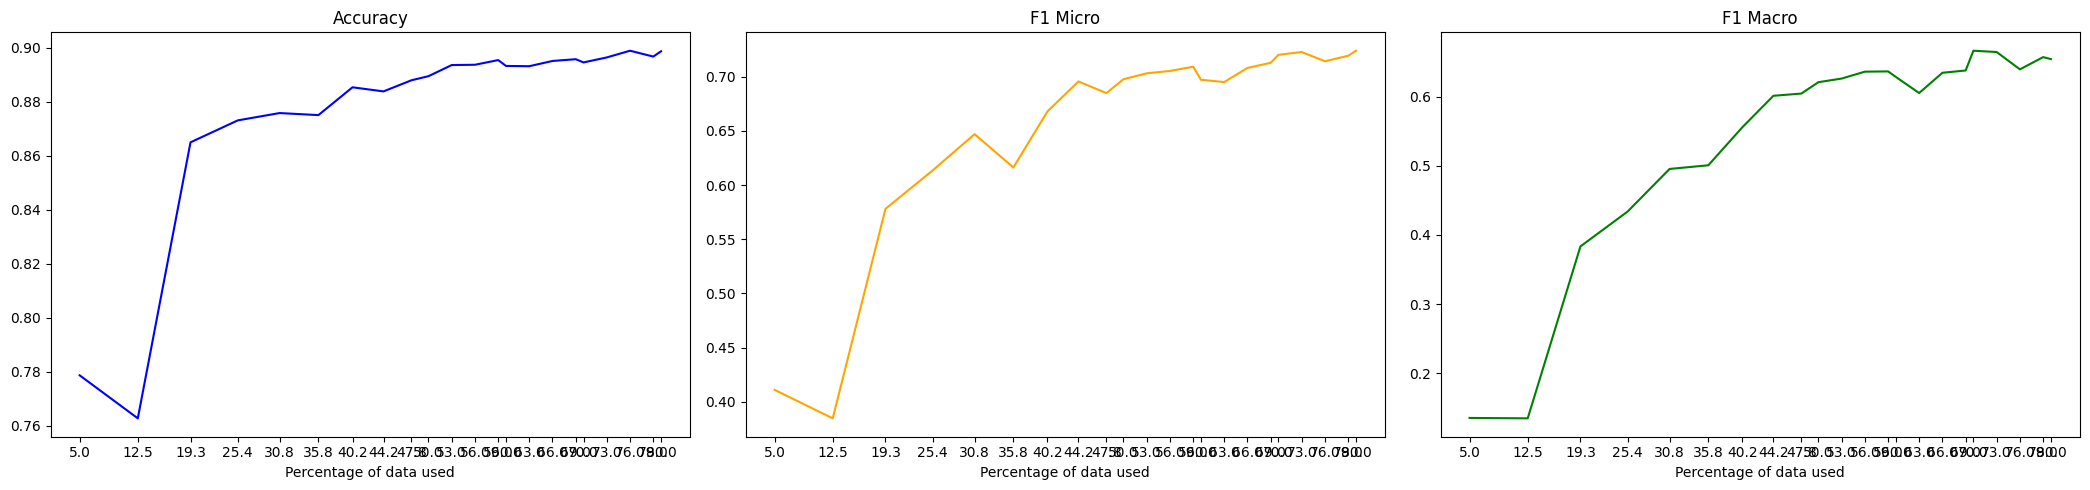

Result saved to results/hsd-coreset-1-results.csv


In [30]:
active_learning(42, 0, 'coreset')

# RANDOM SAMPLING

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.722, Accuracy: 0.6509, F1 Micro: 0.3623, F1 Macro: 0.1898
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.6257, Accuracy: 0.7786, F1 Micro: 0.4111, F1 Macro: 0.135
Epoch 3/10, Train Loss: 0.5647, Accuracy: 0.7998, F1 Micro: 0.4016, F1 Macro: 0.1075
Epoch 4/10, Train Loss: 0.5074, Accuracy: 0.8007, F1 Micro: 0.338, F1 Macro: 0.0861
Epoch 5/10, Train Loss: 0.4635, Accuracy: 0.8061, F1 Micro: 0.2962, F1 Macro: 0.0632
Epoch 6/10, Train Loss: 0.4439, Accuracy: 0.8175, F1 Micro: 0.2737, F1 Macro: 0.0614
Epoch 7/10, Train Loss: 0.4336, Accuracy: 0.8196, F1 Micro: 0.2579, F1 Macro: 0.0613
Epoch 8/10, Train Loss: 0.4161, Accuracy: 0.8205, F1 Micro: 0.2583, F1 Macro: 0.0619
Epoch 9/10, Train Loss: 0.3778, Accuracy: 0.8201, F1 Micro: 0.2366, F1 Macro: 0.0597
Epoch 10/10, Train Loss: 0.3726, Accuracy: 0.8202, F1 Micro: 0.221, F1 Macro: 0.0583
Iteration 166: Accuracy: 0.7786, F1 Micro: 0.4111, F1 Macro: 0.135
               preci

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6789, Accuracy: 0.7758, F1 Micro: 0.4187, F1 Macro: 0.1372
Epoch 2/10, Train Loss: 0.55, Accuracy: 0.8019, F1 Micro: 0.3844, F1 Macro: 0.1034
Epoch 3/10, Train Loss: 0.4623, Accuracy: 0.8168, F1 Micro: 0.2348, F1 Macro: 0.0594
Epoch 4/10, Train Loss: 0.4258, Accuracy: 0.8174, F1 Micro: 0.1881, F1 Macro: 0.0532
Epoch 5/10, Train Loss: 0.4127, Accuracy: 0.8214, F1 Micro: 0.2258, F1 Macro: 0.0642
Epoch 6/10, Train Loss: 0.4072, Accuracy: 0.823, F1 Micro: 0.2317, F1 Macro: 0.0682
Epoch 7/10, Train Loss: 0.3812, Accuracy: 0.8319, F1 Micro: 0.3203, F1 Macro: 0.0983
Epoch 8/10, Train Loss: 0.369, Accuracy: 0.8342, F1 Micro: 0.3402, F1 Macro: 0.1053
Epoch 9/10, Train Loss: 0.3701, Accuracy: 0.8392, F1 Micro: 0.3752, F1 Macro: 0.1216
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.3539, Accuracy: 0.8466, F1 Micro: 0.4321, F1 Macro: 0.1621
Iteration 416: Accuracy: 0.8466, F1 Micro: 0.4321, F1 Macro: 0.1621
               prec

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6423, Accuracy: 0.798, F1 Micro: 0.4235, F1 Macro: 0.1181
Epoch 2/10, Train Loss: 0.4862, Accuracy: 0.8169, F1 Micro: 0.2179, F1 Macro: 0.0584
Epoch 3/10, Train Loss: 0.4369, Accuracy: 0.8159, F1 Micro: 0.1661, F1 Macro: 0.0504
Epoch 4/10, Train Loss: 0.3982, Accuracy: 0.8176, F1 Micro: 0.178, F1 Macro: 0.0542
Epoch 5/10, Train Loss: 0.3806, Accuracy: 0.8362, F1 Micro: 0.3618, F1 Macro: 0.1104
Epoch 6/10, Train Loss: 0.3709, Accuracy: 0.8388, F1 Micro: 0.3714, F1 Macro: 0.1202
Epoch 7/10, Train Loss: 0.3475, Accuracy: 0.8443, F1 Micro: 0.4078, F1 Macro: 0.1571
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3347, Accuracy: 0.8548, F1 Micro: 0.5059, F1 Macro: 0.2364
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2995, Accuracy: 0.8585, F1 Micro: 0.5366, F1 Macro: 0.3217
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2824, Accuracy: 0.86, F1 Micro: 0.5931, F1 Macro: 0.3931
Iteration 641: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6341, Accuracy: 0.7993, F1 Micro: 0.4269, F1 Macro: 0.1184
Epoch 2/10, Train Loss: 0.4736, Accuracy: 0.8124, F1 Micro: 0.1359, F1 Macro: 0.0426
Epoch 3/10, Train Loss: 0.4144, Accuracy: 0.8203, F1 Micro: 0.2122, F1 Macro: 0.0638
Epoch 4/10, Train Loss: 0.398, Accuracy: 0.8262, F1 Micro: 0.2631, F1 Macro: 0.0809
Epoch 5/10, Train Loss: 0.3787, Accuracy: 0.8395, F1 Micro: 0.3855, F1 Macro: 0.1185
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3591, Accuracy: 0.85, F1 Micro: 0.4593, F1 Macro: 0.1689
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3395, Accuracy: 0.8594, F1 Micro: 0.5321, F1 Macro: 0.256
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3046, Accuracy: 0.863, F1 Micro: 0.5481, F1 Macro: 0.3116
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2884, Accuracy: 0.8673, F1 Micro: 0.5941, F1 Macro: 0.3863
Epoch 10/10, Train Loss: 0.2695, Accuracy: 0.8647, F1 Micro: 0.5763, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6007, Accuracy: 0.8038, F1 Micro: 0.4095, F1 Macro: 0.1101
Epoch 2/10, Train Loss: 0.449, Accuracy: 0.8172, F1 Micro: 0.1816, F1 Macro: 0.0559
Epoch 3/10, Train Loss: 0.4131, Accuracy: 0.8255, F1 Micro: 0.2576, F1 Macro: 0.0811
Epoch 4/10, Train Loss: 0.3853, Accuracy: 0.8354, F1 Micro: 0.347, F1 Macro: 0.1094
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3678, Accuracy: 0.8524, F1 Micro: 0.4692, F1 Macro: 0.1916
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3286, Accuracy: 0.8614, F1 Micro: 0.5457, F1 Macro: 0.3056
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3146, Accuracy: 0.8663, F1 Micro: 0.5966, F1 Macro: 0.3718
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2752, Accuracy: 0.867, F1 Micro: 0.6195, F1 Macro: 0.4095
Epoch 9/10, Train Loss: 0.2543, Accuracy: 0.869, F1 Micro: 0.594, F1 Macro: 0.3831
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2225, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5861, Accuracy: 0.8115, F1 Micro: 0.375, F1 Macro: 0.1014
Epoch 2/10, Train Loss: 0.4368, Accuracy: 0.8189, F1 Micro: 0.2003, F1 Macro: 0.0637
Epoch 3/10, Train Loss: 0.4074, Accuracy: 0.8313, F1 Micro: 0.3195, F1 Macro: 0.0993
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3809, Accuracy: 0.8455, F1 Micro: 0.4281, F1 Macro: 0.1508
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.351, Accuracy: 0.8572, F1 Micro: 0.4981, F1 Macro: 0.235
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3174, Accuracy: 0.8659, F1 Micro: 0.5905, F1 Macro: 0.3614
Epoch 7/10, Train Loss: 0.2758, Accuracy: 0.8697, F1 Micro: 0.5869, F1 Macro: 0.3843
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2548, Accuracy: 0.8726, F1 Micro: 0.6256, F1 Macro: 0.4326
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2398, Accuracy: 0.8737, F1 Micro: 0.63, F1 Macro: 0.4666
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5793, Accuracy: 0.8176, F1 Micro: 0.3051, F1 Macro: 0.0782
Epoch 2/10, Train Loss: 0.4242, Accuracy: 0.8185, F1 Micro: 0.1883, F1 Macro: 0.061
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3938, Accuracy: 0.8346, F1 Micro: 0.3425, F1 Macro: 0.1061
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3611, Accuracy: 0.8493, F1 Micro: 0.4464, F1 Macro: 0.1772
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3292, Accuracy: 0.8622, F1 Micro: 0.5402, F1 Macro: 0.3069
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.302, Accuracy: 0.8699, F1 Micro: 0.6096, F1 Macro: 0.4051
Epoch 7/10, Train Loss: 0.281, Accuracy: 0.8727, F1 Micro: 0.606, F1 Macro: 0.4082
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2501, Accuracy: 0.8739, F1 Micro: 0.6508, F1 Macro: 0.5067
Epoch 9/10, Train Loss: 0.225, Accuracy: 0.8774, F1 Micro: 0.6444, F1 Macro: 0.4925
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5676, Accuracy: 0.8177, F1 Micro: 0.2664, F1 Macro: 0.0673
Epoch 2/10, Train Loss: 0.4202, Accuracy: 0.8188, F1 Micro: 0.1901, F1 Macro: 0.0583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3845, Accuracy: 0.8406, F1 Micro: 0.4079, F1 Macro: 0.1236
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.362, Accuracy: 0.8572, F1 Micro: 0.5004, F1 Macro: 0.215
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3309, Accuracy: 0.864, F1 Micro: 0.5415, F1 Macro: 0.3161
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2881, Accuracy: 0.8714, F1 Micro: 0.6265, F1 Macro: 0.4127
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2582, Accuracy: 0.8765, F1 Micro: 0.6362, F1 Macro: 0.4544
Epoch 8/10, Train Loss: 0.2344, Accuracy: 0.8758, F1 Micro: 0.632, F1 Macro: 0.468
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2128, Accuracy: 0.8836, F1 Micro: 0.6783, F1 Macro: 0.5716
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5602, Accuracy: 0.8179, F1 Micro: 0.2122, F1 Macro: 0.0581
Epoch 2/10, Train Loss: 0.4026, Accuracy: 0.8175, F1 Micro: 0.1771, F1 Macro: 0.0541
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3859, Accuracy: 0.8394, F1 Micro: 0.3739, F1 Macro: 0.1201
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3471, Accuracy: 0.8611, F1 Micro: 0.5308, F1 Macro: 0.257
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3087, Accuracy: 0.8683, F1 Micro: 0.6303, F1 Macro: 0.3953
Epoch 6/10, Train Loss: 0.2878, Accuracy: 0.872, F1 Micro: 0.6176, F1 Macro: 0.4064
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2508, Accuracy: 0.8761, F1 Micro: 0.6337, F1 Macro: 0.4727
Epoch 8/10, Train Loss: 0.2256, Accuracy: 0.877, F1 Micro: 0.6245, F1 Macro: 0.4669
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2092, Accuracy: 0.8815, F1 Micro: 0.6434, F1 Macro: 0.5134
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5587, Accuracy: 0.8177, F1 Micro: 0.2068, F1 Macro: 0.0567
Epoch 2/10, Train Loss: 0.4158, Accuracy: 0.8154, F1 Micro: 0.1533, F1 Macro: 0.0484
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3768, Accuracy: 0.8417, F1 Micro: 0.4013, F1 Macro: 0.1226
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3362, Accuracy: 0.8588, F1 Micro: 0.5092, F1 Macro: 0.2327
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3255, Accuracy: 0.8672, F1 Micro: 0.6149, F1 Macro: 0.4028
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2839, Accuracy: 0.8735, F1 Micro: 0.6234, F1 Macro: 0.4286
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2554, Accuracy: 0.8768, F1 Micro: 0.653, F1 Macro: 0.4908
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2323, Accuracy: 0.8838, F1 Micro: 0.6898, F1 Macro: 0.5768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2121, Accuracy: 0.885, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5456, Accuracy: 0.8141, F1 Micro: 0.164, F1 Macro: 0.0473
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4103, Accuracy: 0.8172, F1 Micro: 0.1712, F1 Macro: 0.0531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3767, Accuracy: 0.8443, F1 Micro: 0.4145, F1 Macro: 0.1511
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3417, Accuracy: 0.864, F1 Micro: 0.5722, F1 Macro: 0.308
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.306, Accuracy: 0.8709, F1 Micro: 0.6156, F1 Macro: 0.4183
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2649, Accuracy: 0.8716, F1 Micro: 0.6334, F1 Macro: 0.4513
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.239, Accuracy: 0.8768, F1 Micro: 0.6421, F1 Macro: 0.5016
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2148, Accuracy: 0.8811, F1 Micro: 0.6446, F1 Macro: 0.5322
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.19

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5507, Accuracy: 0.8108, F1 Micro: 0.1156, F1 Macro: 0.0368
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.401, Accuracy: 0.8239, F1 Micro: 0.2531, F1 Macro: 0.0723
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3801, Accuracy: 0.8496, F1 Micro: 0.4513, F1 Macro: 0.1731
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3252, Accuracy: 0.8618, F1 Micro: 0.5333, F1 Macro: 0.3123
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2896, Accuracy: 0.8728, F1 Micro: 0.6172, F1 Macro: 0.4211
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2605, Accuracy: 0.8773, F1 Micro: 0.6447, F1 Macro: 0.4786
Epoch 7/10, Train Loss: 0.2328, Accuracy: 0.8758, F1 Micro: 0.6443, F1 Macro: 0.487
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2079, Accuracy: 0.8864, F1 Micro: 0.6918, F1 Macro: 0.6032
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1902, Accuracy: 0.8877, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5361, Accuracy: 0.811, F1 Micro: 0.1103, F1 Macro: 0.0361
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4003, Accuracy: 0.8392, F1 Micro: 0.3901, F1 Macro: 0.1181
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3689, Accuracy: 0.8523, F1 Micro: 0.4588, F1 Macro: 0.1944
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3197, Accuracy: 0.8659, F1 Micro: 0.5636, F1 Macro: 0.3539
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2891, Accuracy: 0.872, F1 Micro: 0.6206, F1 Macro: 0.4161
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2611, Accuracy: 0.8783, F1 Micro: 0.6481, F1 Macro: 0.4774
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2294, Accuracy: 0.8852, F1 Micro: 0.6864, F1 Macro: 0.5679
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2035, Accuracy: 0.8835, F1 Micro: 0.6933, F1 Macro: 0.5795
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5323, Accuracy: 0.8108, F1 Micro: 0.1111, F1 Macro: 0.0359
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4018, Accuracy: 0.8358, F1 Micro: 0.3553, F1 Macro: 0.11
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3649, Accuracy: 0.8561, F1 Micro: 0.4939, F1 Macro: 0.21
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3288, Accuracy: 0.8689, F1 Micro: 0.5949, F1 Macro: 0.3656
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2803, Accuracy: 0.8712, F1 Micro: 0.6099, F1 Macro: 0.4087
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2474, Accuracy: 0.875, F1 Micro: 0.649, F1 Macro: 0.4945
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2253, Accuracy: 0.8845, F1 Micro: 0.6907, F1 Macro: 0.5764
Epoch 8/10, Train Loss: 0.2052, Accuracy: 0.8877, F1 Micro: 0.6906, F1 Macro: 0.6023
Epoch 9/10, Train Loss: 0.1738, Accuracy: 0.8865, F1 Micro: 0.6604, F1 Macro: 0.5398
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5319, Accuracy: 0.8129, F1 Micro: 0.1354, F1 Macro: 0.0431
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4041, Accuracy: 0.8401, F1 Micro: 0.4066, F1 Macro: 0.122
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3685, Accuracy: 0.8559, F1 Micro: 0.4981, F1 Macro: 0.2347
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3121, Accuracy: 0.8683, F1 Micro: 0.5707, F1 Macro: 0.358
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.276, Accuracy: 0.8729, F1 Micro: 0.6382, F1 Macro: 0.4463
Epoch 6/10, Train Loss: 0.2482, Accuracy: 0.8777, F1 Micro: 0.6265, F1 Macro: 0.4712
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.218, Accuracy: 0.8855, F1 Micro: 0.7037, F1 Macro: 0.6125
Epoch 8/10, Train Loss: 0.1935, Accuracy: 0.8878, F1 Micro: 0.7024, F1 Macro: 0.6264
Epoch 9/10, Train Loss: 0.174, Accuracy: 0.8878, F1 Micro: 0.691, F1 Macro: 0.6109
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5221, Accuracy: 0.8132, F1 Micro: 0.1321, F1 Macro: 0.0413
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4033, Accuracy: 0.8378, F1 Micro: 0.3679, F1 Macro: 0.1146
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3519, Accuracy: 0.8609, F1 Micro: 0.5301, F1 Macro: 0.271
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3101, Accuracy: 0.8697, F1 Micro: 0.6308, F1 Macro: 0.4446
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.271, Accuracy: 0.8778, F1 Micro: 0.64, F1 Macro: 0.4373
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2398, Accuracy: 0.8831, F1 Micro: 0.6815, F1 Macro: 0.5486
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2045, Accuracy: 0.8892, F1 Micro: 0.7012, F1 Macro: 0.605
Epoch 8/10, Train Loss: 0.181, Accuracy: 0.8896, F1 Micro: 0.6908, F1 Macro: 0.607
Epoch 9/10, Train Loss: 0.1572, Accuracy: 0.8883, F1 Micro: 0.6787, F1 Macro: 0.5775
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5215, Accuracy: 0.811, F1 Micro: 0.1094, F1 Macro: 0.0356
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.392, Accuracy: 0.8408, F1 Micro: 0.4281, F1 Macro: 0.1245
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3551, Accuracy: 0.8635, F1 Micro: 0.5592, F1 Macro: 0.2805
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.307, Accuracy: 0.87, F1 Micro: 0.5928, F1 Macro: 0.3672
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2756, Accuracy: 0.8788, F1 Micro: 0.6432, F1 Macro: 0.459
Epoch 6/10, Train Loss: 0.2431, Accuracy: 0.8781, F1 Micro: 0.625, F1 Macro: 0.4632
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2196, Accuracy: 0.8836, F1 Micro: 0.6603, F1 Macro: 0.5394
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1922, Accuracy: 0.8869, F1 Micro: 0.675, F1 Macro: 0.5694
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.158, Accuracy: 0.8936, F1 Micro: 0.704

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5182, Accuracy: 0.8141, F1 Micro: 0.1507, F1 Macro: 0.0453
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3969, Accuracy: 0.8367, F1 Micro: 0.3555, F1 Macro: 0.1111
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3501, Accuracy: 0.8643, F1 Micro: 0.5502, F1 Macro: 0.2895
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2981, Accuracy: 0.8723, F1 Micro: 0.6373, F1 Macro: 0.4179
Epoch 5/10, Train Loss: 0.2639, Accuracy: 0.8742, F1 Micro: 0.6109, F1 Macro: 0.4118
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2352, Accuracy: 0.8837, F1 Micro: 0.6616, F1 Macro: 0.5187
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2033, Accuracy: 0.8872, F1 Micro: 0.6746, F1 Macro: 0.5626
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1815, Accuracy: 0.8905, F1 Micro: 0.694, F1 Macro: 0.6075
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.16, Accuracy: 0.8952, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5179, Accuracy: 0.8201, F1 Micro: 0.2157, F1 Macro: 0.0707
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.394, Accuracy: 0.8391, F1 Micro: 0.3719, F1 Macro: 0.1234
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3416, Accuracy: 0.864, F1 Micro: 0.5728, F1 Macro: 0.3163
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.302, Accuracy: 0.8683, F1 Micro: 0.5799, F1 Macro: 0.3845
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2642, Accuracy: 0.879, F1 Micro: 0.6416, F1 Macro: 0.4604
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2401, Accuracy: 0.8813, F1 Micro: 0.6525, F1 Macro: 0.5044
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2088, Accuracy: 0.8867, F1 Micro: 0.6694, F1 Macro: 0.5454
Epoch 8/10, Train Loss: 0.1868, Accuracy: 0.8845, F1 Micro: 0.6502, F1 Macro: 0.5522
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1607, Accuracy: 0.891, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5169, Accuracy: 0.8178, F1 Micro: 0.1955, F1 Macro: 0.0573
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3893, Accuracy: 0.8396, F1 Micro: 0.379, F1 Macro: 0.1254
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3404, Accuracy: 0.8656, F1 Micro: 0.5693, F1 Macro: 0.3212
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3001, Accuracy: 0.8732, F1 Micro: 0.6081, F1 Macro: 0.3927
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2628, Accuracy: 0.8755, F1 Micro: 0.6226, F1 Macro: 0.4561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2321, Accuracy: 0.8875, F1 Micro: 0.6916, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2007, Accuracy: 0.8908, F1 Micro: 0.6963, F1 Macro: 0.5863
Epoch 8/10, Train Loss: 0.1706, Accuracy: 0.8869, F1 Micro: 0.67, F1 Macro: 0.5904
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1512, Accuracy: 0.8941, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5122, Accuracy: 0.8188, F1 Micro: 0.194, F1 Macro: 0.0636
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3882, Accuracy: 0.8455, F1 Micro: 0.423, F1 Macro: 0.151
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3332, Accuracy: 0.8657, F1 Micro: 0.5737, F1 Macro: 0.3697
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2976, Accuracy: 0.8758, F1 Micro: 0.6259, F1 Macro: 0.4328
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2547, Accuracy: 0.8813, F1 Micro: 0.6607, F1 Macro: 0.4833
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2239, Accuracy: 0.8857, F1 Micro: 0.6989, F1 Macro: 0.5778
Epoch 7/10, Train Loss: 0.1952, Accuracy: 0.887, F1 Micro: 0.6752, F1 Macro: 0.5768
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1734, Accuracy: 0.8925, F1 Micro: 0.7005, F1 Macro: 0.6247
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1485, Accuracy: 0.8932, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5083, Accuracy: 0.8184, F1 Micro: 0.1983, F1 Macro: 0.0574
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3901, Accuracy: 0.843, F1 Micro: 0.4023, F1 Macro: 0.131
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3375, Accuracy: 0.8652, F1 Micro: 0.5526, F1 Macro: 0.3287
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2857, Accuracy: 0.8742, F1 Micro: 0.6315, F1 Macro: 0.4191
Epoch 5/10, Train Loss: 0.2431, Accuracy: 0.8774, F1 Micro: 0.6203, F1 Macro: 0.458
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.227, Accuracy: 0.8831, F1 Micro: 0.6463, F1 Macro: 0.5166
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1961, Accuracy: 0.8927, F1 Micro: 0.7004, F1 Macro: 0.6015
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1756, Accuracy: 0.8952, F1 Micro: 0.7035, F1 Macro: 0.6227
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1496, Accuracy: 0.8978, F1 Micro: 

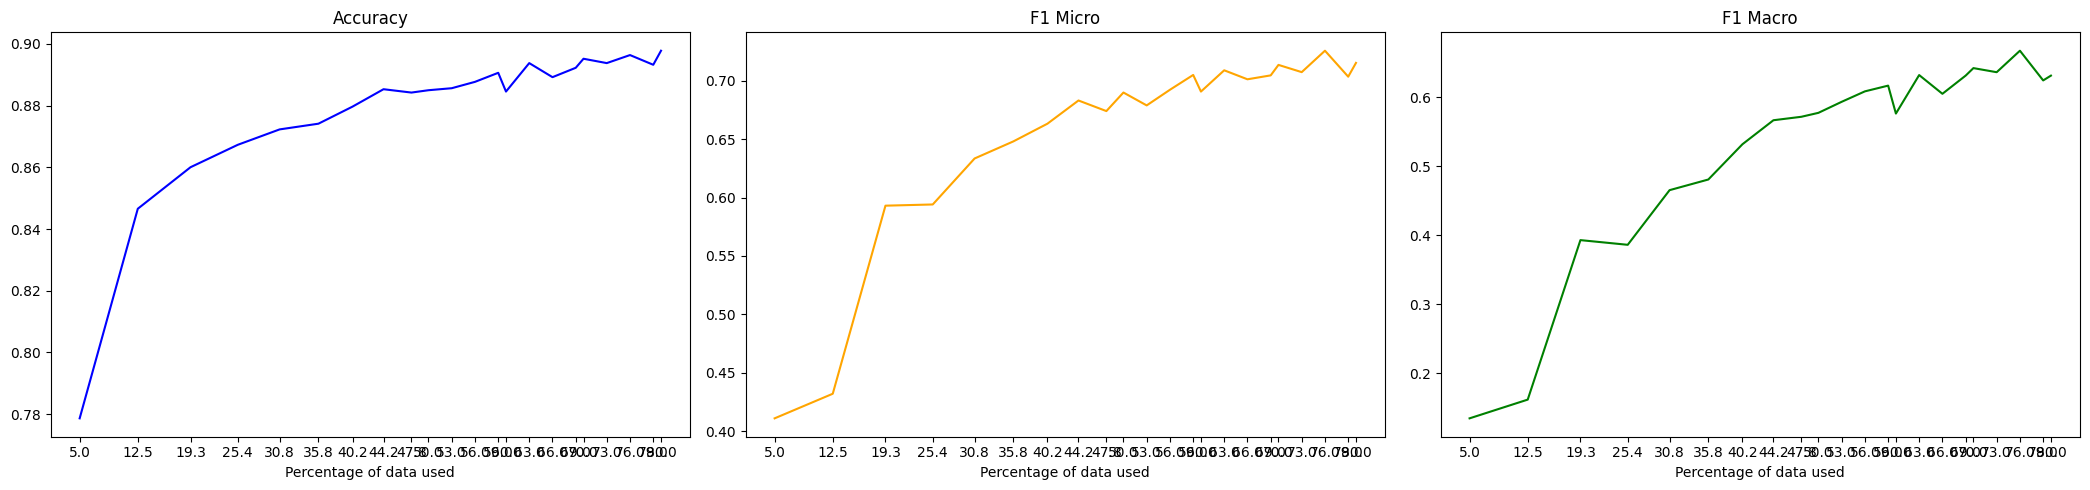

Result saved to results/hsd-random-1-results.csv


In [31]:
active_learning(42, 0, 'random')